# Data Cleaning and processing (Base dataset)

Actions to be implemented here :

1) Inspection of the data
2) Data Cleaning
3) Descriptive statistics & Visualization


## Data Import and Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from pathlib import Path
DATADIR= Path("/workspaces/fraud-detection-BAF-Dataset-Suite-/FraudDataset")
data_dir =DATADIR
if not data_dir.exists():
    raise FileNotFoundError(f"Data directory not found: {data_dir}")
extension = "csv"  # Change to "csv" if needed
data_paths = [str(p) for p in sorted(data_dir.glob(f"*.{extension}"))]
data_paths[0]
dataset=pd.read_csv(data_paths[0], index_col=0)


In [3]:
dataset.head(5)
dataset.reset_index(inplace=True)

Questions for columns: 

1) How come the intended_balcon_amount is <0? ===> **Answer**: <0 are missing values => user did not transfer any amount or not recorded from the system.
2) What does credit_risk_score reflect => **Answer** The higher, the riskier.
3) Why month has only 7 values? I would expect 12. **Answer** Probably, these would be months of new banking accounts creation marketing campaing.
4) keep_alive_session=1 reflects that the user did not made a logout? **Answer** Yes.

5) I think that a "distinct" separation is whether the user is already customer of the bank. For example, the prev_address_months_count should be >0 only for applicants who have registered also their own previous address => they have redistered another time in the past in bank. Also there may be cases that a customer has cards in the bank (has_binary_cards=yes) but no current account (bank_months_count<0~missing) who may be a customer with different product than an account (e.g. card). Such customer may be considered card holder but without enough financial stability. In general, we will consider the **interaction of has_other_cards, bank_months_count, prev_address_months_count and current_address_months_count** to create a customer profile with multiple levels.


### Inspect which of them need filling their own missing values

1. **prev_address_month_count**: -1 here may imply that there is not even a previous registered address of the applicant => so no need for them to impute here an approximation for them. **No need also** for deleting such cases. **No need here for imputing---> Give proper focus on such customers not having previous address valid duration (either staying for long time to the current address or no valid duration implying potential fraud or just wrong application).**.

2. **current_address_month_count**: Similarly, with above.

3. **intended_balcon_amount**: Since <0 implies that user did not transfer any amount at the beginning, this means that he has  not made initially any transfer  for the application. Then, such cases should not be imputed since they contain important info since the fact that they did not make intitial transfer may be a distinction between fraud and non-fraud. **No need here for imputing**.

4. **velocity_6h**? why negative number? here is not something provided by the user but from the system. so since the velocity is <0, we may need to impute here to have an approximation.  **Need here for imputing: How? ---> Good solution would be to find applications within last 6 hours and impute the mean of velocity_6h for then. However, 44 only observations were found to be missing and all of them are cases with days_since_request<=0.25, last 6 hours**.

5. **credit_risk_score**: Negative number here may indicate very low score. **No need here for imputing**.

6. **bank_months_count**: Here <0 implies that the previous account of user is not existent. So he is **either** new user  **or** a user without previous prdocut in the bank . **===> Answer** The cases where <0 denote missingness rather than a patterna nd such cases will be evaluated under potential interaction with other features such as has_other_cards, bank_months_count, prev_address_months_count and current_address_months_count.

7. **session_length_in_minutes**: Both teleapp and internet (Source feature) presented missingness. **=> Answer**. **Need here for imputing. First, log the covariate and then impute. Another transformation techniques could be tested but this one produces symmetrical distribution**.

8. **device_distinct_emails**: Probably here the 0 implies that during last 8 weeks there was not another e-mail (another from the original one) that appeared. So, the missing value implies tha the "monitoring" system of the bank did not recognize such info which means that during the last 8 weeks the user was not even apparent (thus, reasonable to have missing value) or the system did not work properly -> need to impute such cases.
Let's be sure about cases where the days_since_request was almost 0 which means that  in such cases the system may not have had the necessary time to detect such info. From below, it seems that there are missing cases where the days of request were >0 which implies that such missing cases are not solely cases of very "freshly" registered people. Thus, probably, there was system dis-functionality ===>**ANSWER: Need for imputing or to separate them as category**.



#### **Income**

In [4]:
dataset["income"].value_counts()

income
0.9    221419
0.1    157449
0.8    146650
0.6    111973
0.7    105109
0.4     81364
0.2     69345
0.5     55858
0.3     50833
Name: count, dtype: int64

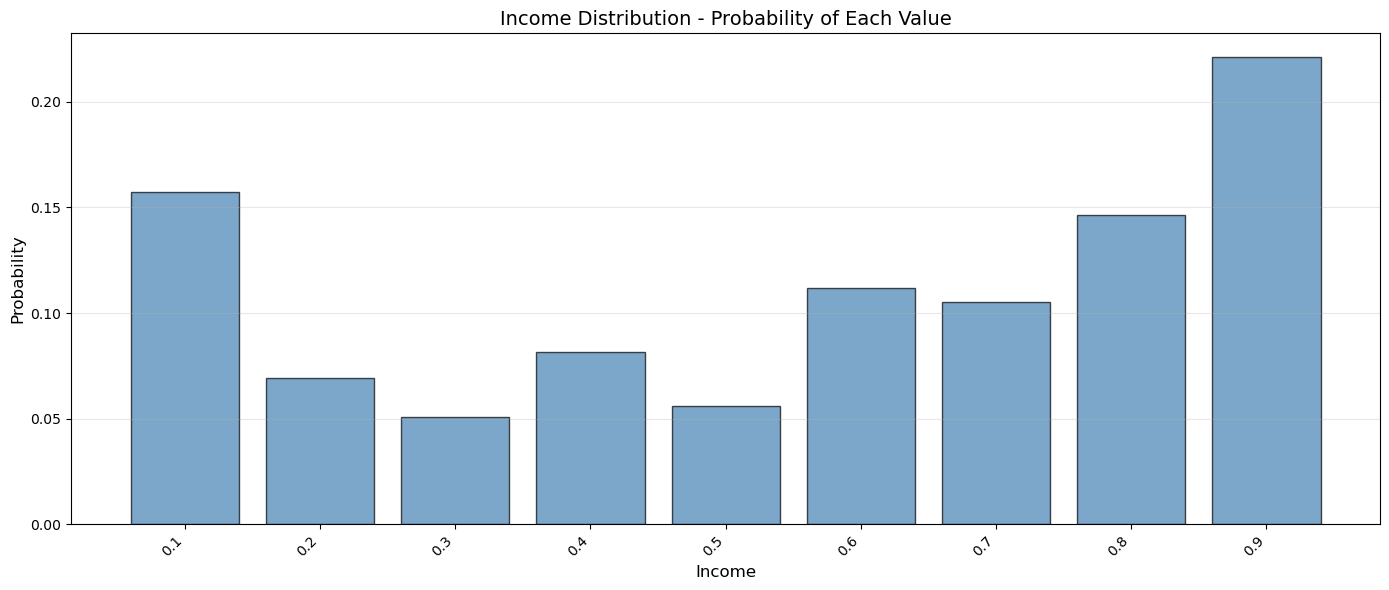

Income Probabilities:
income
0.1    0.157449
0.2    0.069345
0.3    0.050833
0.4    0.081364
0.5    0.055858
0.6    0.111973
0.7    0.105109
0.8    0.146650
0.9    0.221419
Name: count, dtype: float64


In [5]:
# Calculate probabilities for each income value
income_counts = dataset['income'].value_counts().sort_index()
income_probabilities = income_counts / len(dataset)

# Create barplot with probabilities on y-axis
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(income_probabilities)), income_probabilities.values, color='steelblue', edgecolor='black', alpha=0.7)

# Set x-axis with formatted income labels
plt.xticks(range(len(income_probabilities)), [f'{x:.1f}' for x in income_probabilities.index], rotation=45, ha='right')

# Add labels and title
plt.xlabel('Income', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Income Distribution - Probability of Each Value', fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display the probabilities
print("Income Probabilities:")
print(income_probabilities)

### name_email_similarity

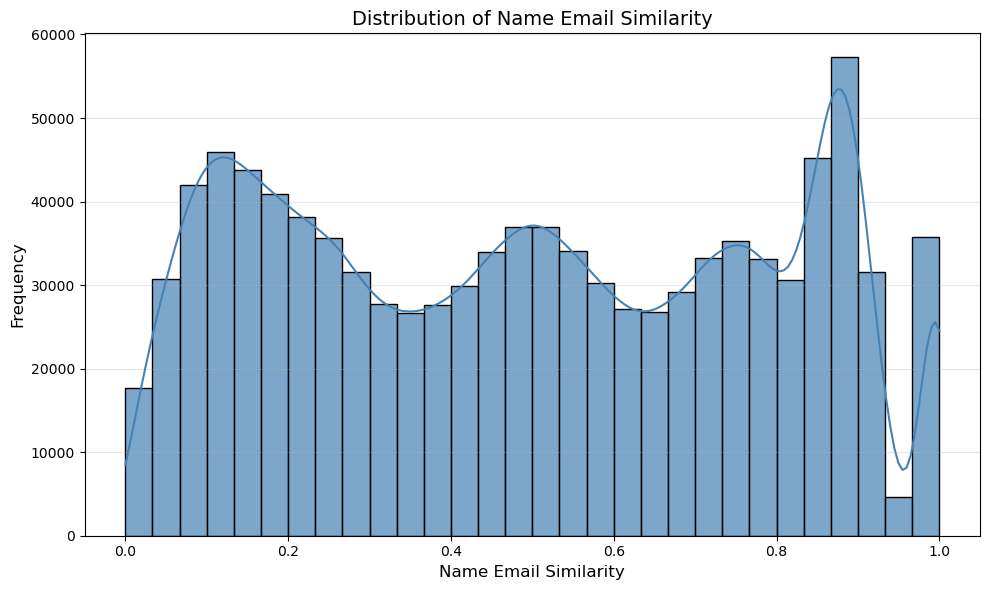

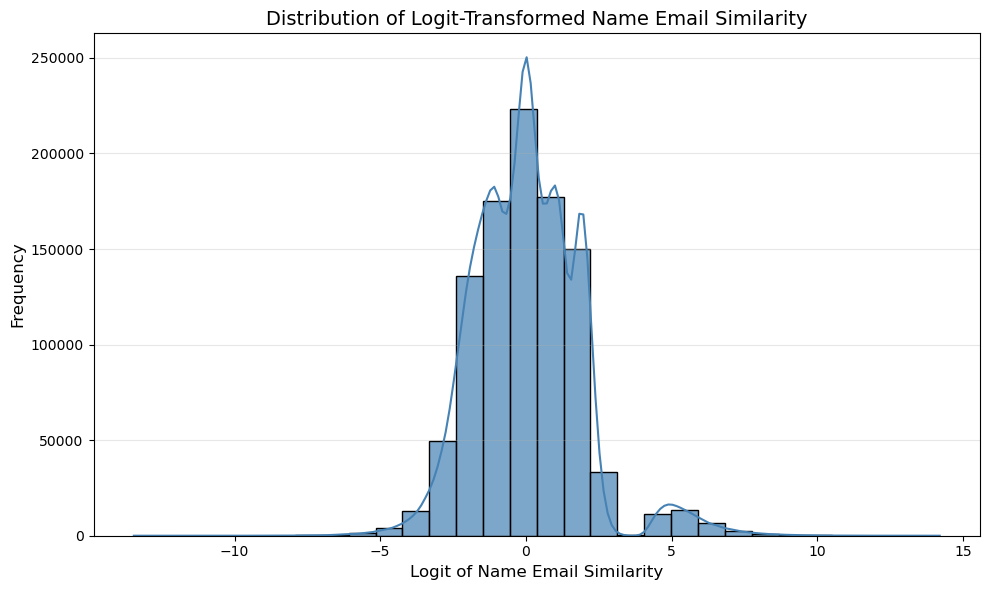

In [6]:
# Visualise through histogram the values of name_email_similarity continuous variable 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['name_email_similarity'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Name Email Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Name Email Similarity', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Apply logit transformation
dataset['name_email_similarity_logit'] = np.log(dataset['name_email_similarity'] / (1 - dataset['name_email_similarity']))
# Visualise the logit-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset['name_email_similarity_logit'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Logit of Name Email Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Logit-Transformed Name Email Similarity', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Now the logit transformation seems more symmetrical and closer to the normal distribution. Also, the reason behind such transformation is due to the "stretching" of the distribution to a wider distribution and second, it can now separate better the customers with extreme similarity scores between each others such as between users with 0.9 and 1.0. However, this separation of such customers may be also noisy and thus both features (non logit and logit will be considered). **Even** many transformations such as target encoding after binning to a categorical feature, etc.. but not preferred such complex logics at this moment.

### **customer_age**

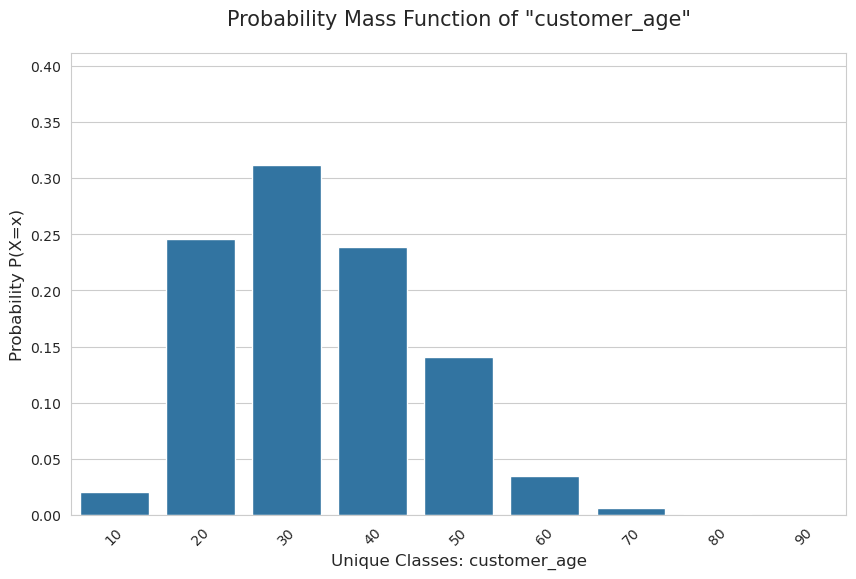

In [7]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["customer_age"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["customer_age", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="customer_age", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "customer_age"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: customer_age', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()


**Consider target encoding in future.**

### **Days_since_request**

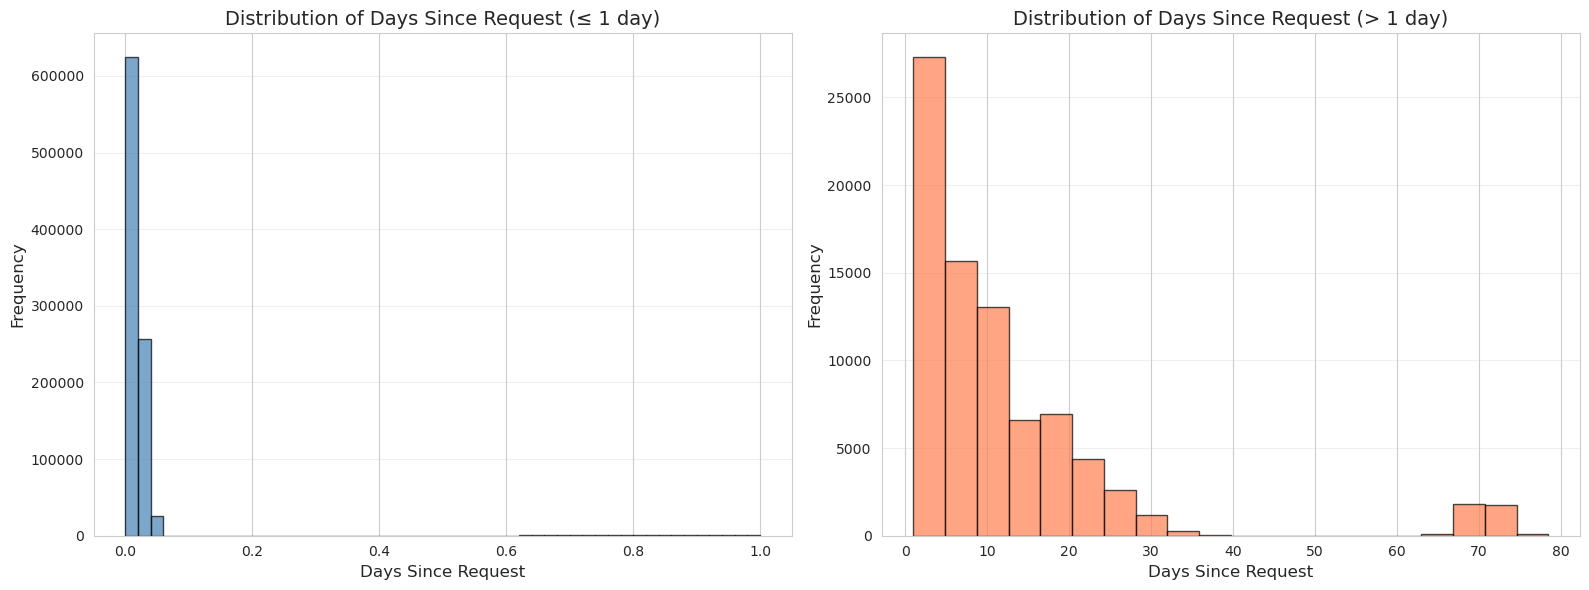

Recent requests (≤ 1 day): 918267 records (91.83%)
Older requests (> 1 day): 81733 records (8.17%)

Recent requests statistics:
count    9.182670e+05
mean     2.440972e-02
std      8.215392e-02
min      4.036860e-09
25%      6.587945e-03
50%      1.375588e-02
75%      2.296980e-02
max      9.999907e-01
Name: days_since_request, dtype: float64

Older requests statistics:
count    81733.000000
mean        12.275220
std         14.713461
min          1.000005
25%          3.018993
50%          8.396725
75%         15.818792
max         78.456904
Name: days_since_request, dtype: float64


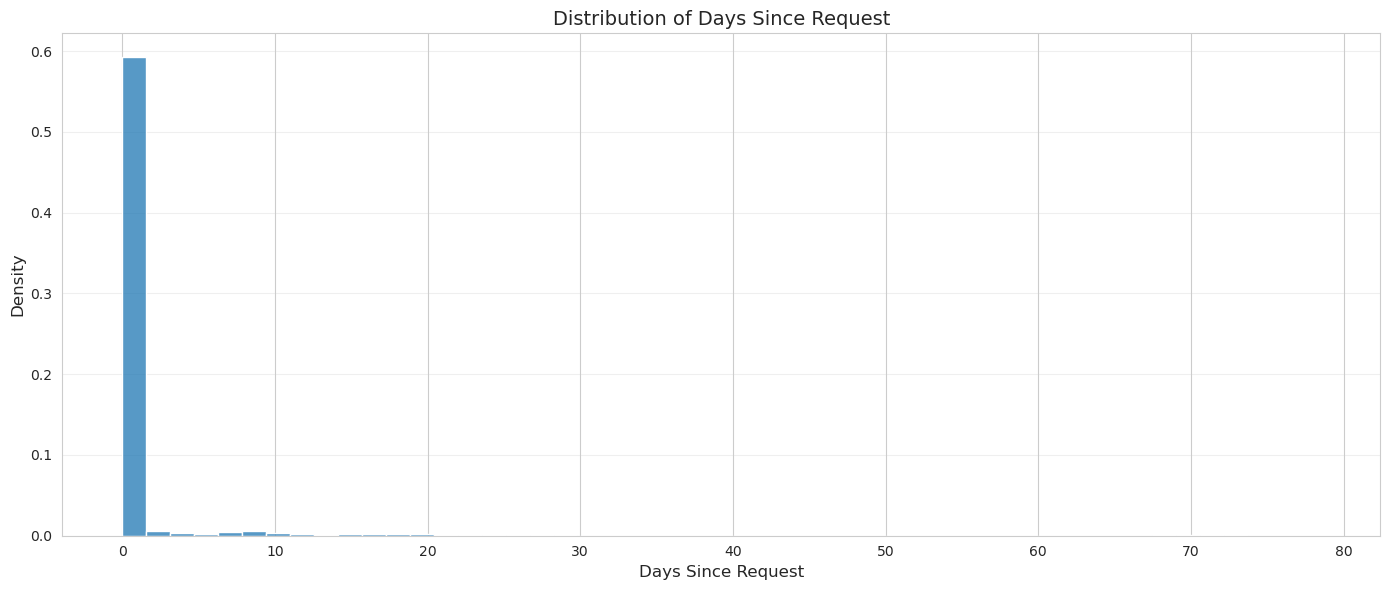

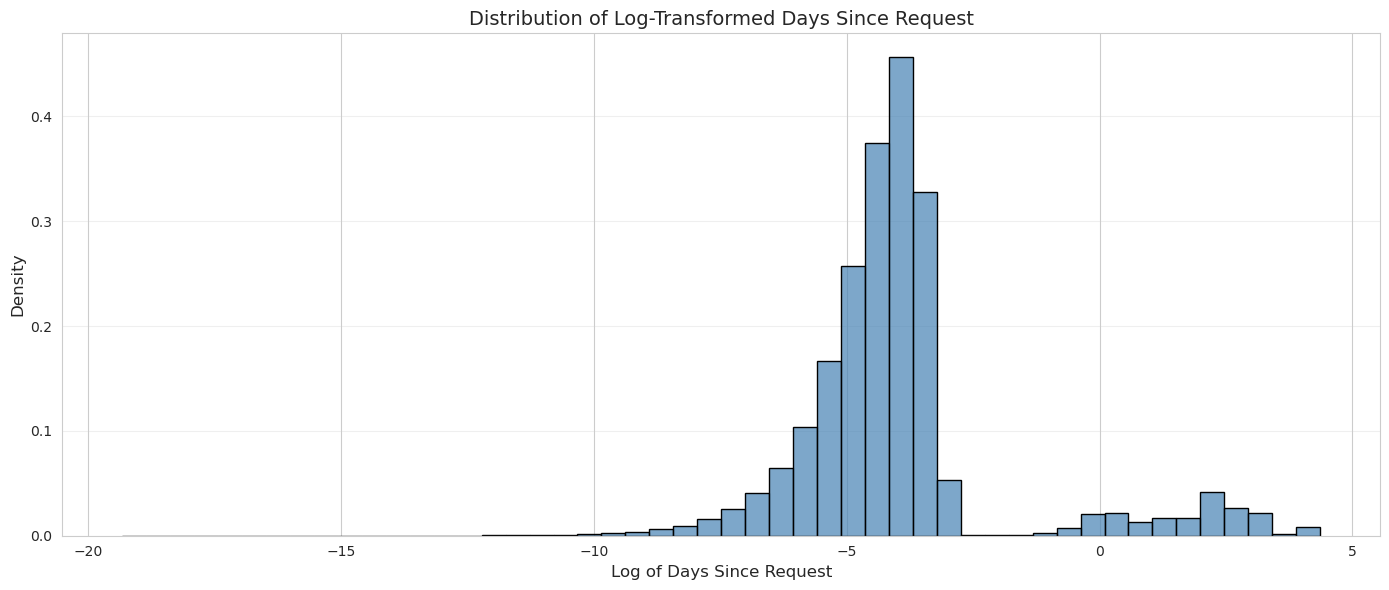

In [8]:
# Visualise through histogram the days_since_request. Visualise clear the distribution until days_since_request==1 and for the remaining use much wider bins since they are more rare values

# Split data into two regions: days_since_request <= 1 and > 1
data_recent = dataset[dataset['days_since_request'] <= 1]['days_since_request']
data_older = dataset[dataset['days_since_request'] > 1]['days_since_request']

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Recent requests (days_since_request <= 1) with fine bins
axes[0].hist(data_recent, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Days Since Request', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Days Since Request (≤ 1 day)', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Older requests (days_since_request > 1) with wider bins
axes[1].hist(data_older, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Days Since Request', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Days Since Request (> 1 day)', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Recent requests (≤ 1 day): {len(data_recent)} records ({len(data_recent)/len(dataset)*100:.2f}%)")
print(f"Older requests (> 1 day): {len(data_older)} records ({len(data_older)/len(dataset)*100:.2f}%)")
print(f"\nRecent requests statistics:\n{data_recent.describe()}")
print(f"\nOlder requests statistics:\n{data_older.describe()}")


# Visualise through histogram the days_since_request. Visualise clear the distribution until days_since_request==1 and for the remaining use much wider bins since they are more rare values
plt.figure(figsize=(14, 6))
sns.histplot(data=dataset, x='days_since_request', bins=50,  stat='density')
plt.xlabel('Days Since Request', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Days Since Request', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

dataset["days_since_request"].quantile([0.001,0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
# Calculate log-transformed days_since_request
dataset['days_since_request_log'] = np.log(dataset['days_since_request'])
# Visualise the log-transformed values from negative to positive x-axis values
plt.figure(figsize=(14, 6))
sns.histplot(data=dataset, x='days_since_request_log', bins=50, stat='density', color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Days Since Request', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Log-Transformed Days Since Request', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Split data into three categories (days=[0,1]-->"Immediate", 1<days<=7 implies "Standard", >7 implies "Delayed")

dataset["days_since_request_binned"] = np.where(dataset["days_since_request"]<=1, "Immediate", np.where((dataset["days_since_request"]>1) & (dataset["days_since_request"]<=7), "Standard", "Delayed"))

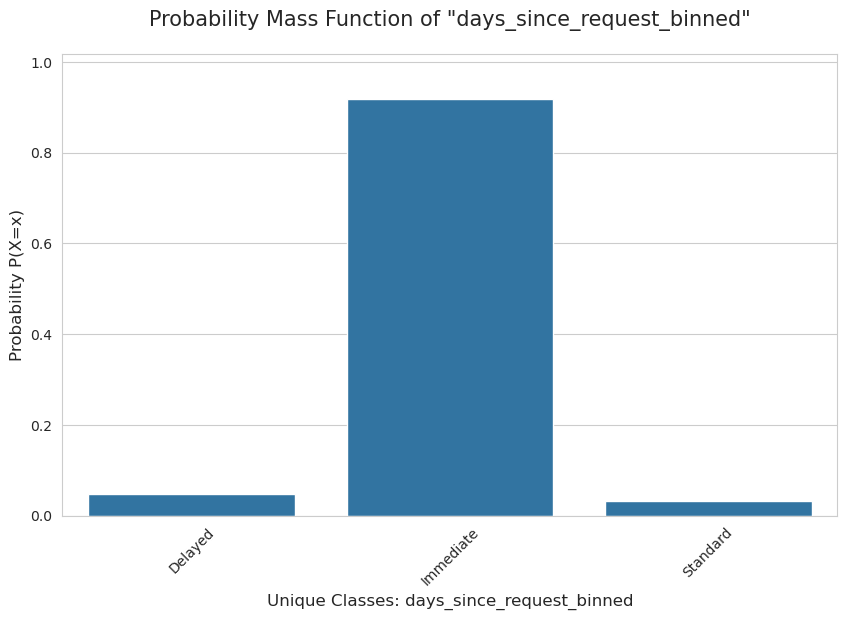

,days_since_request_binned,probability
0,Delayed,0.048598
1,Immediate,0.918267
2,Standard,0.033135


In [10]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["days_since_request_binned"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["days_since_request_binned", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="days_since_request_binned", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "days_since_request_binned"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: days_since_request_binned', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
# Proportions
prob_df


### **intended_balcon_amount**

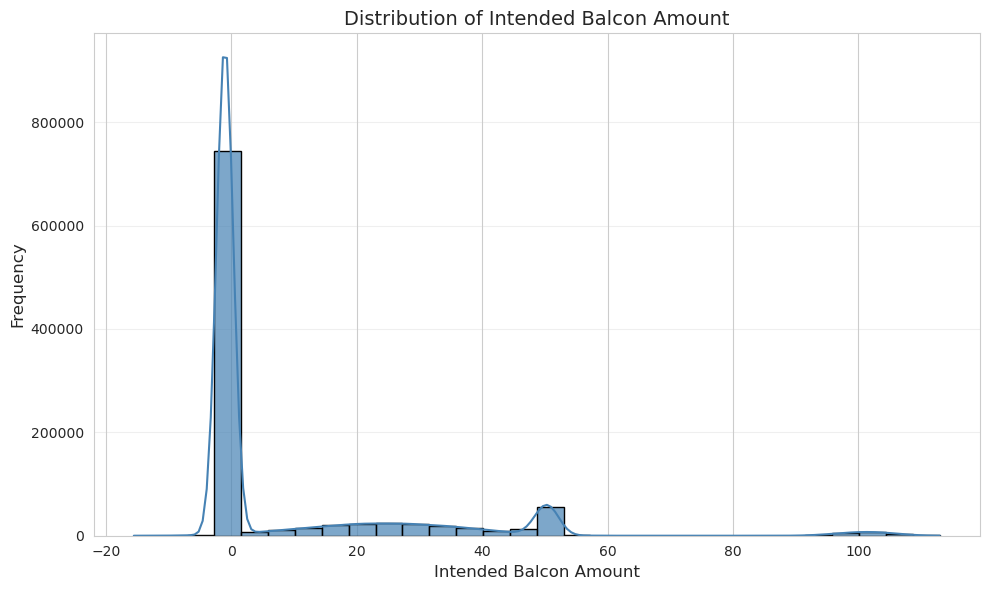

Descriptive statistics of intended_balcon_amount: 
count    1000000.000000
mean           8.661499
std           20.236155
min          -15.530555
25%           -1.181488
50%           -0.830507
75%            4.984176
max          112.956928
Name: intended_balcon_amount, dtype: float64
Proportions of binary validation feature of valid transferred amount: 
valid_transferred_amount
missing    0.742523
Valid      0.257477
Name: proportion, dtype: float64
quantiles: 
0.001     -4.405512
0.250     -1.181488
0.500     -0.830507
0.750      4.984176
0.800     19.101772
0.850     28.246028
0.900     39.763094
0.950     50.394003
0.990    100.826524
Name: intended_balcon_amount, dtype: float64


In [11]:
# Visualualize the distribution of intended_balcon_amount using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(dataset['intended_balcon_amount'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Intended Balcon Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Intended Balcon Amount', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Descriptive statistics of intended_balcon_amount: \n{dataset['intended_balcon_amount'].describe()}")
# Apply binning to missing or non missing
dataset["valid_transferred_amount"]=np.where(dataset["intended_balcon_amount"]<0,"missing","Valid")
print(f"Proportions of binary validation feature of valid transferred amount: \n{dataset['valid_transferred_amount'].value_counts(normalize=True)}")
print(f"quantiles: \n{dataset['intended_balcon_amount'].quantile([0.001,0.25, 0.5, 0.75,0.8,0.85, 0.9, 0.95, 0.99])}")



Apply a decision tree classifier with specific main hyper-parameter values will help us find the best cut-off points to create meaningful bins in terms of how they affect the fraud rate.

In [12]:
from sklearn.tree import DecisionTreeClassifier

# We use a slightly higher depth but strict leaf requirements
dt_binning = DecisionTreeClassifier(
    max_depth=3, 
    min_samples_leaf=0.05, # Each bin must have at least 5% of data
    random_state=42
)
x = dataset.loc[dataset['intended_balcon_amount'] > 0, 'intended_balcon_amount'].values.reshape(-1, 1)
y = dataset.loc[dataset['intended_balcon_amount'] > 0, 'fraud_bool'].values
# Fit on training data only to avoid leakage
dt_binning.fit(x, y)

# The 'thresholds' will now respect your quantile spikes (0, 50, 100)
thresholds = dt_binning.tree_.threshold
print(f"Optimal bin boundaries found: {thresholds[thresholds != -2]}")

Optimal bin boundaries found: [92.11529541 51.49590683 19.69488239]


Create now the categorical feature of intended_balcon_amount

In [13]:
dataset["intended_balcon_amount_binned"] = pd.cut(dataset['intended_balcon_amount'], bins=[-np.inf, 0,  20, 52,92, np.inf], labels=['Missing/Negative', '0-20', '20-52', '52-92', '92+'])

### payment_type

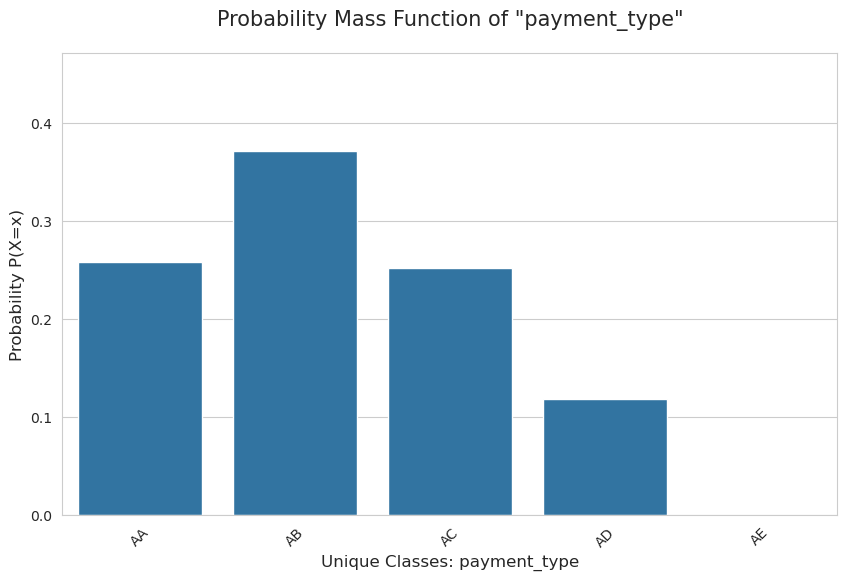

,payment_type,probability
0,AA,0.258249
1,AB,0.370554
2,AC,0.252071
3,AD,0.118837
4,AE,0.000289


In [14]:
dataset["payment_type"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["payment_type"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["payment_type", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="payment_type", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "payment_type"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: payment_type', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
# Proportions
prob_df

**Class AE** should be combined with others based on the influence on the target variable and the distribution of the data. If Class AE has a very small number of instances or if it does not show a significant difference in the target variable compared to other classes, it may be beneficial to combine it with a similar class to improve model performance and reduce noise (next notebook).

### zip_count_4w

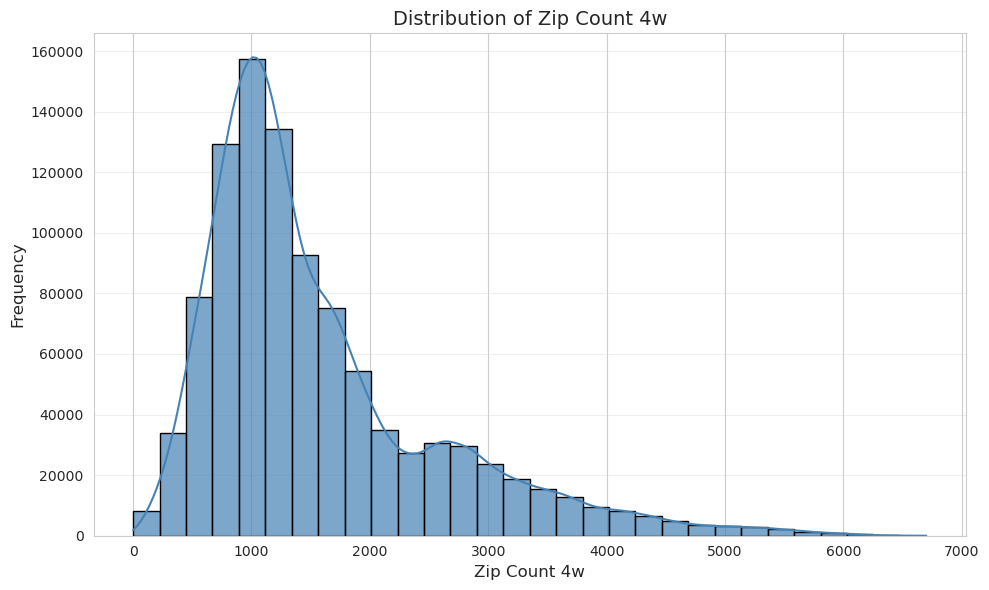

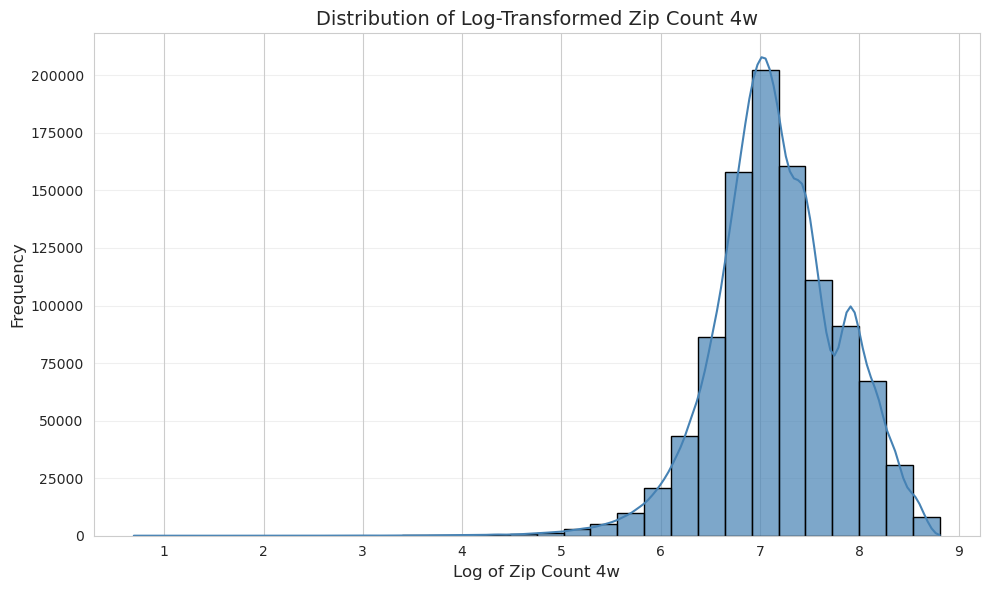

In [15]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['zip_count_4w'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Zip Count 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Zip Count 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
dataset['zip_count_4w_log'] = np.log1p(dataset['zip_count_4w'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset['zip_count_4w_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Zip Count 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Zip Count 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

**Remove unnecessary variable of raw zip count**

In [16]:
dataset.drop(columns={"zip_count_4w"}, inplace=True)

### velocity_6h

In [17]:
dataset['velocity_6h'].describe()

count    1000000.000000
mean        5665.296605
std         3009.380665
min         -170.603072
25%         3436.365848
50%         5319.769349
75%         7680.717827
max        16715.565404
Name: velocity_6h, dtype: float64

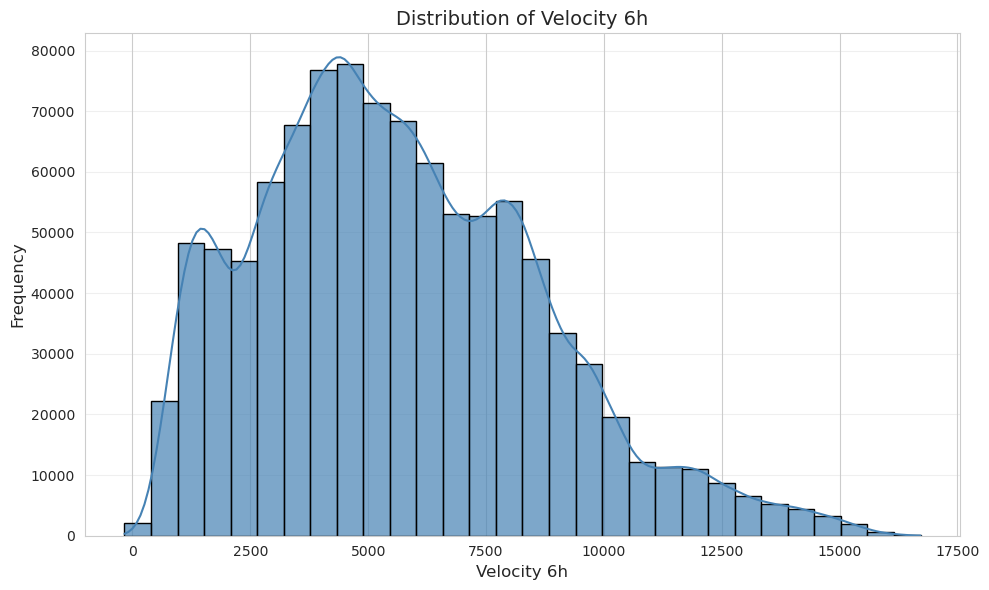

/home/codespace/miniforge3/envs/mlops/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


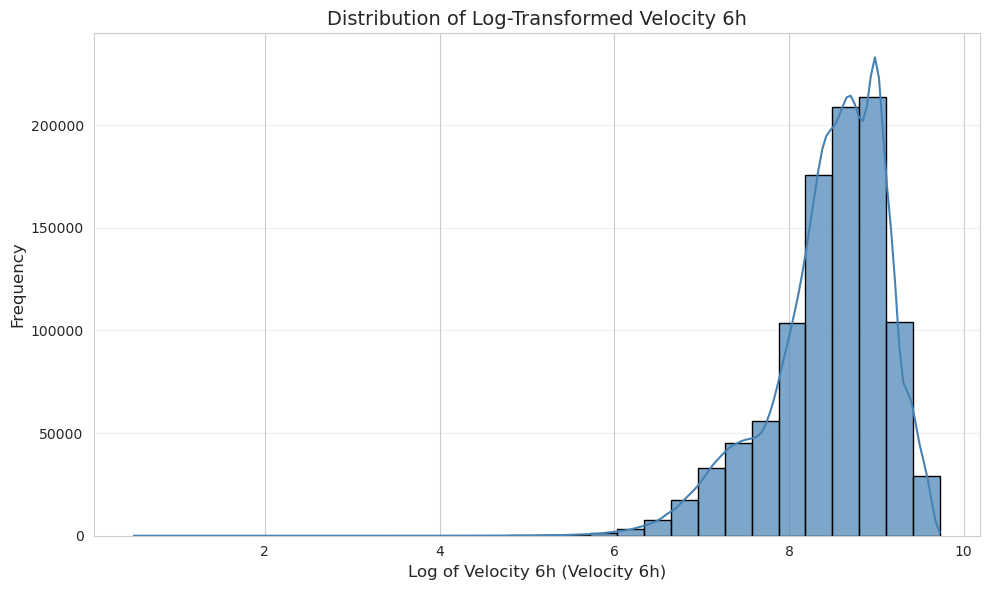

In [18]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['velocity_6h'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Velocity 6h', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Velocity 6h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
dataset['velocity_6h_log'] =dataset['velocity_6h']
dataset['velocity_6h_log']=np.where(dataset['velocity_6h']>0, np.log1p(dataset['velocity_6h']), dataset['velocity_6h'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset.loc[dataset['velocity_6h'] > 0, 'velocity_6h_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Velocity 6h (Velocity 6h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Velocity 6h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

**Need to impute missing value first** and then apply log.

In [19]:
dataset["velocity_6h_valid"]=np.where(dataset["velocity_6h"]<0,"missing","Valid")
dataset["velocity_6h_valid"].value_counts(normalize=True)

velocity_6h_valid
Valid      0.999956
missing    0.000044
Name: proportion, dtype: float64

### Velocity 24h

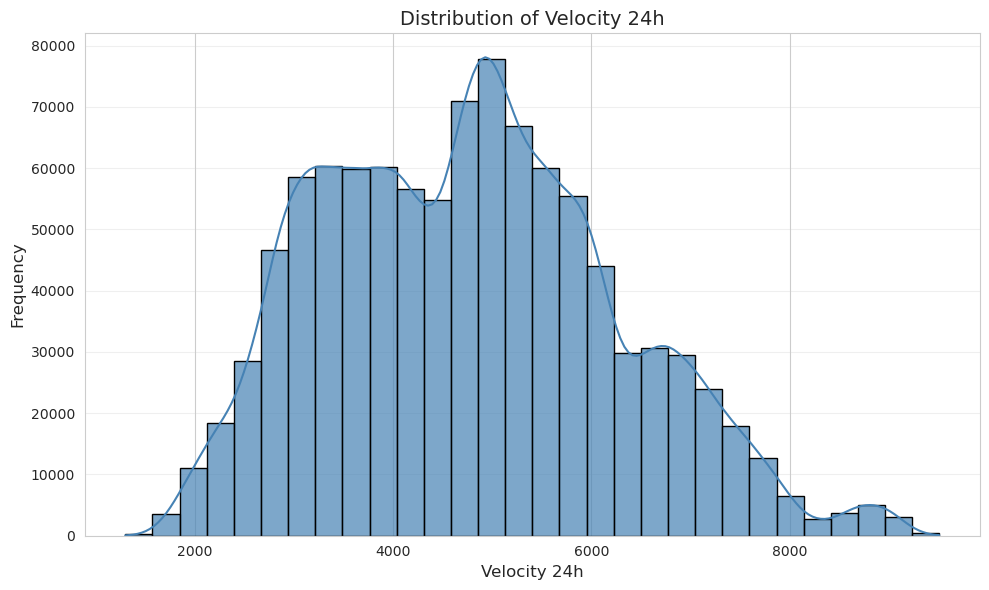

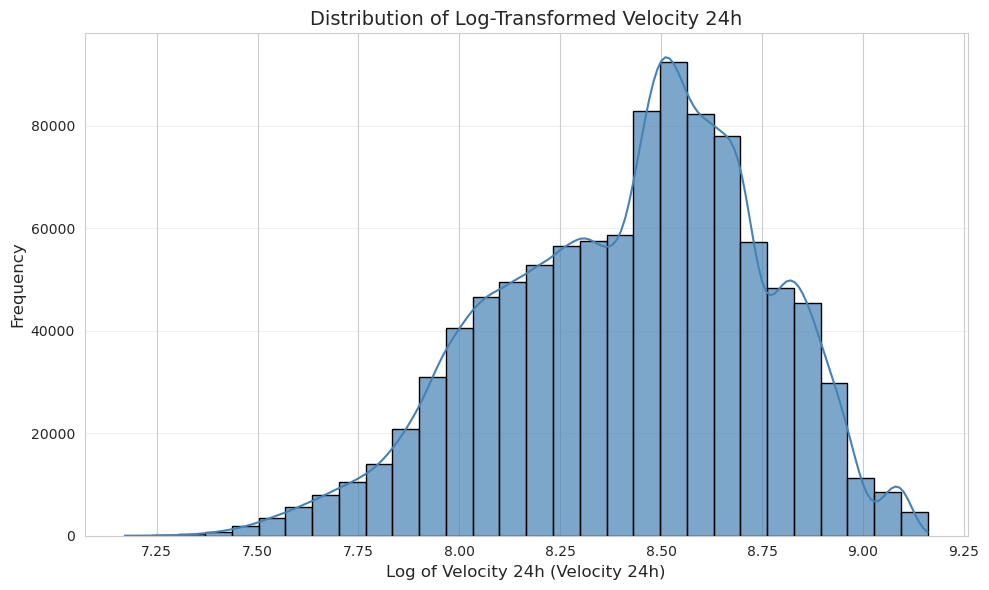

In [20]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['velocity_24h'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Velocity 24h', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Velocity 24h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
dataset['velocity_24h_log'] =dataset['velocity_24h']
dataset['velocity_24h_log']=np.where(dataset['velocity_24h']>0, np.log1p(dataset['velocity_24h']), dataset['velocity_24h'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset['velocity_24h_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Velocity 24h (Velocity 24h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Velocity 24h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

### Velocity 4w

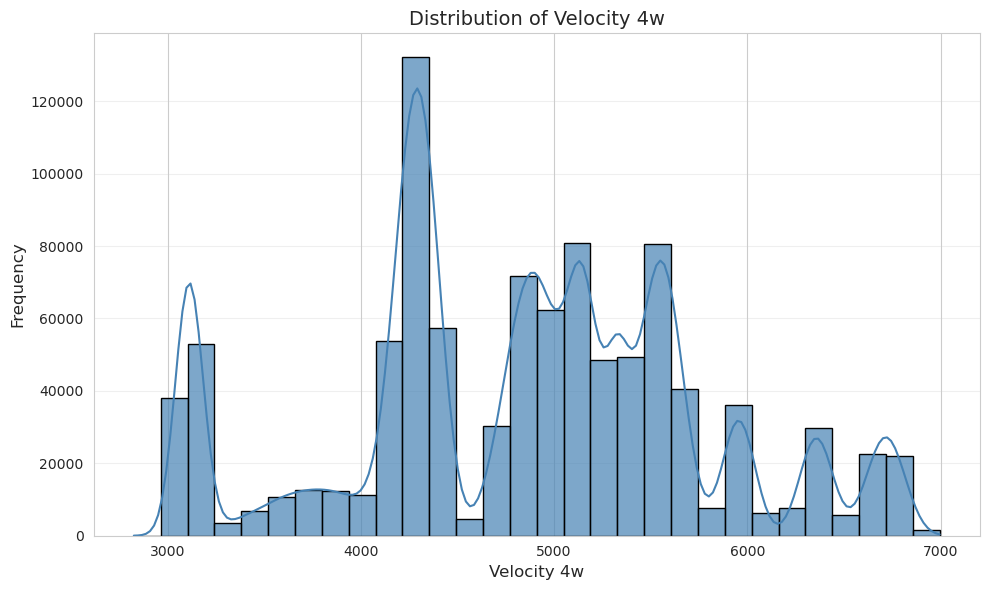

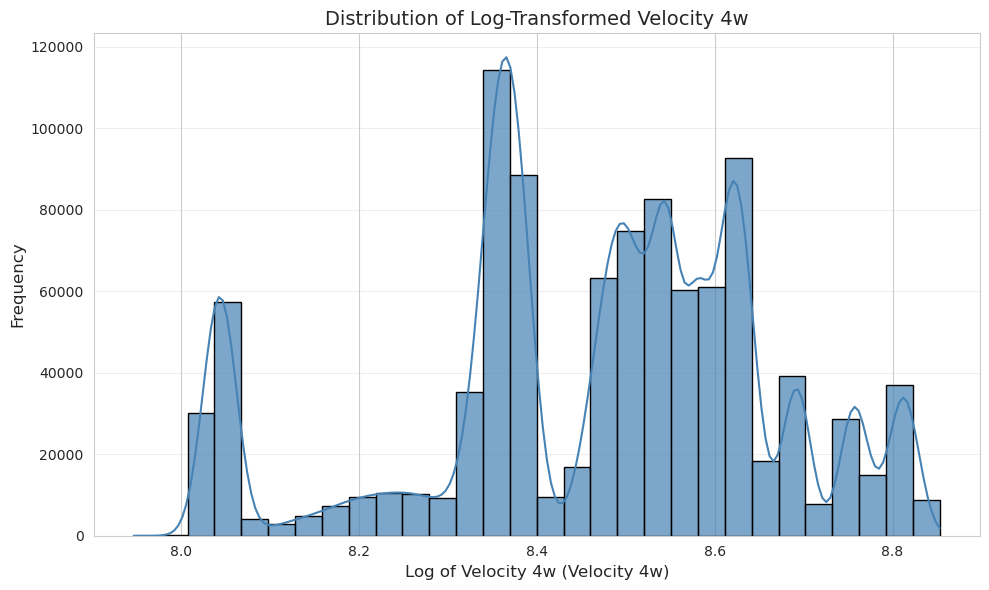

In [21]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['velocity_4w'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Velocity 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Velocity 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
dataset['velocity_4w_log'] =dataset['velocity_4w']
dataset['velocity_4w_log']=np.where(dataset['velocity_4w']>0, np.log1p(dataset['velocity_4w']), dataset['velocity_4w'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset['velocity_4w_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Velocity 4w (Velocity 4w)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Velocity 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

### **bank_branch_count_8w**

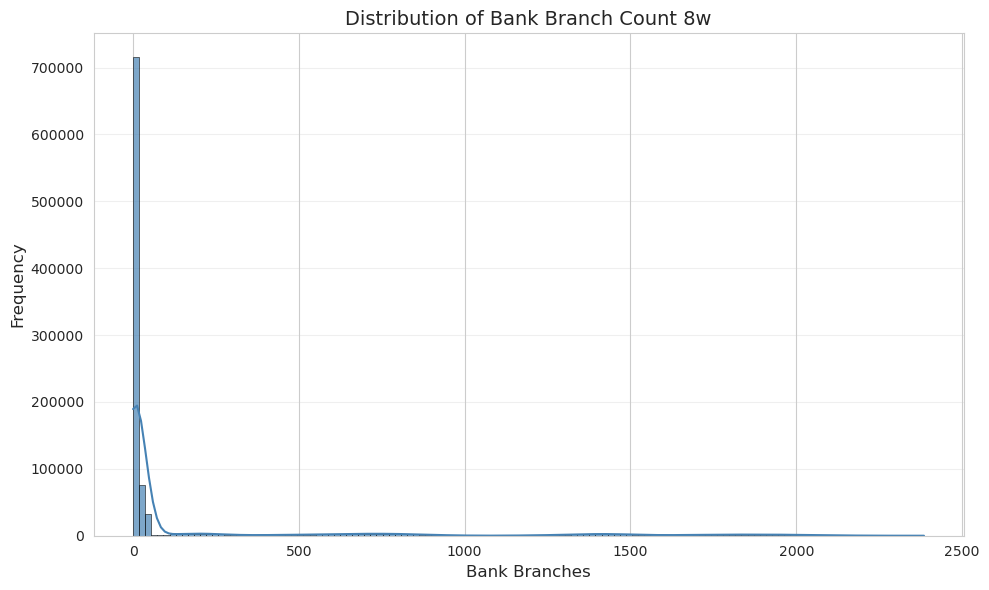

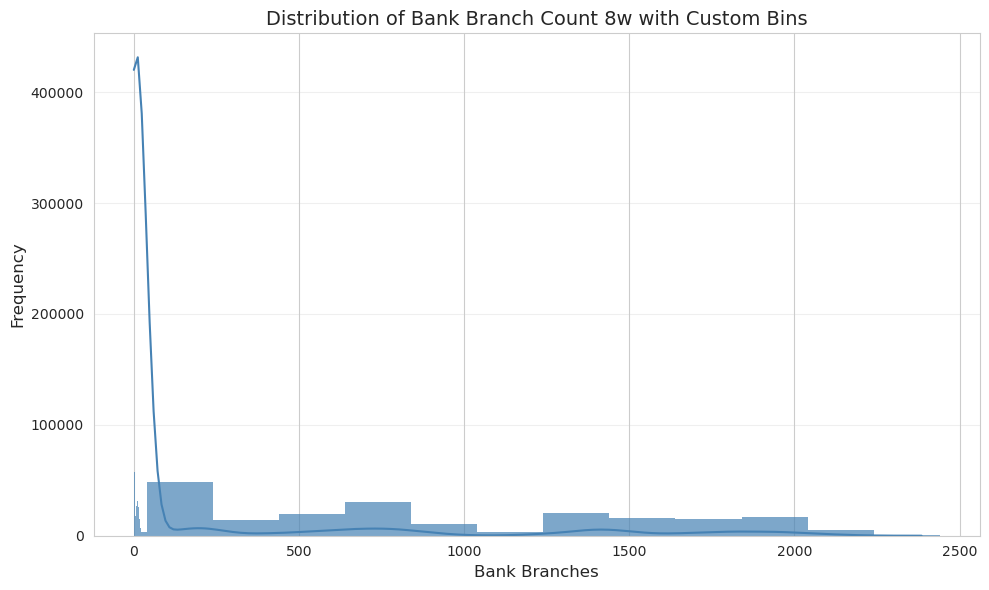

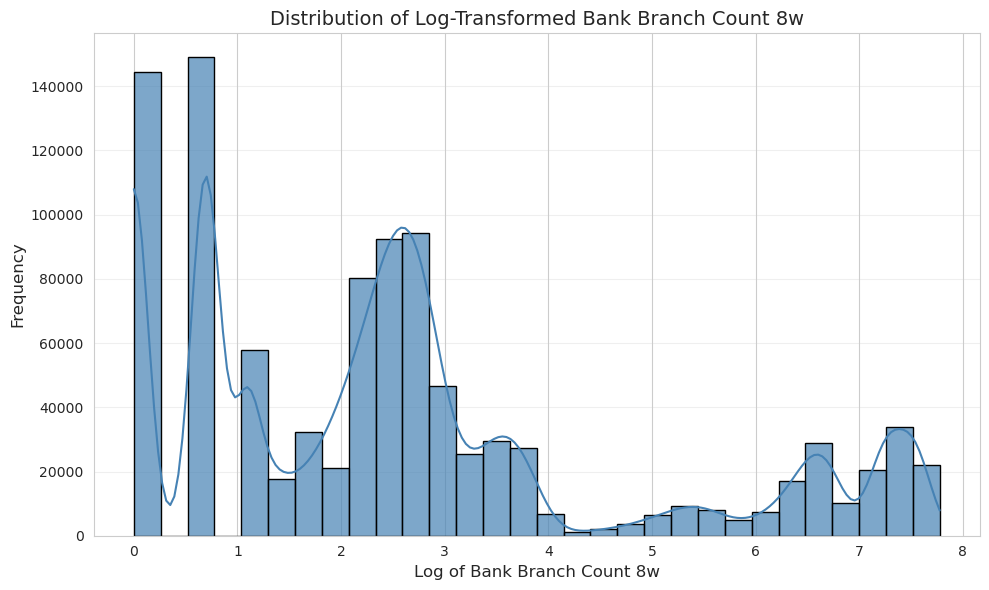

Quantiles of bank_branch_count_8w: 
0.001       0.0
0.250       1.0
0.500       9.0
0.750      25.0
0.900     750.0
0.950    1463.0
0.990    1974.0
Name: bank_branch_count_8w, dtype: float64


In [22]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['bank_branch_count_8w'], bins=130, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Bank Branches', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Bank Branch Count 8w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Create custom bins
narrow_bins = np.arange(0, 41, 1)  # Bins from 0 to 40 with a width of 1
wide_bins = np.arange(40, dataset['bank_branch_count_8w'].max() + 200, 200)  # Bins from 40 to max with a width of
combined_bins = np.concatenate((narrow_bins, wide_bins))
plt.figure(figsize=(10, 6))
sns.histplot(dataset['bank_branch_count_8w'], bins=combined_bins, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Bank Branches', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Bank Branch Count 8w with Custom Bins', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# log transform bank_branch_count_8w to reduce skewness
dataset['bank_branch_count_8w_log'] = np.log1p(dataset['bank_branch_count_8w'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset['bank_branch_count_8w_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Bank Branch Count 8w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Bank Branch Count 8w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

# Print the quantiles of bank_branch_count_8w to understand the distribution and the presence of outliers
print(f"Quantiles of bank_branch_count_8w: \n{dataset['bank_branch_count_8w'].quantile([0.001,0.25, 0.5, 0.75, 0.9, 0.95, 0.99])}")

In [23]:
dataset['bank_branch_count_8w'].describe()
dataset['bank_branch_count_8w'].quantile([0.001,0.25, 0.5, 0.75,0.8,0.85, 0.9, 0.95, 0.99])
# Discretise bank_branch_count_8w into bins based on quantiles (e.g. 80th quantile, 85th, 90th, 95th, 100th)
dataset['bank_branch_count_8w_binned'] = pd.cut(dataset['bank_branch_count_8w'], bins=[-1, dataset['bank_branch_count_8w'].quantile(0.8), dataset['bank_branch_count_8w'].quantile(0.85), dataset['bank_branch_count_8w'].quantile(0.9), dataset['bank_branch_count_8w'].quantile(0.95), dataset['bank_branch_count_8w'].max()], labels=['<=40', '<250', '<=750', '<=1463', '>1463'])

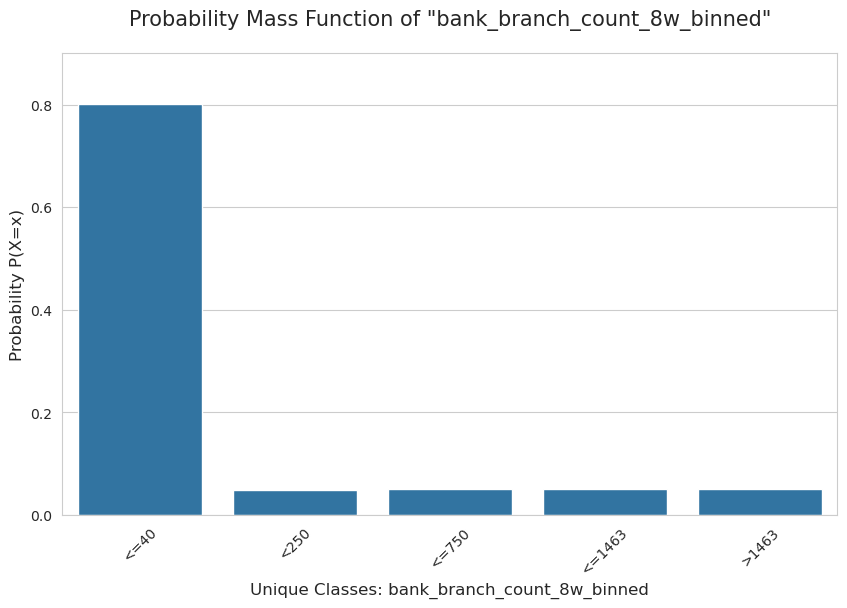

In [24]:
dataset["bank_branch_count_8w_binned"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["bank_branch_count_8w_binned"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["bank_branch_count_8w_binned", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="bank_branch_count_8w_binned", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "bank_branch_count_8w_binned"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: bank_branch_count_8w_binned', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()

### date_of_birth_distinct_emails_4w

In [25]:
dataset['date_of_birth_distinct_emails_4w'].describe()

count    1000000.000000
mean           9.503544
std            5.033792
min            0.000000
25%            6.000000
50%            9.000000
75%           13.000000
max           39.000000
Name: date_of_birth_distinct_emails_4w, dtype: float64

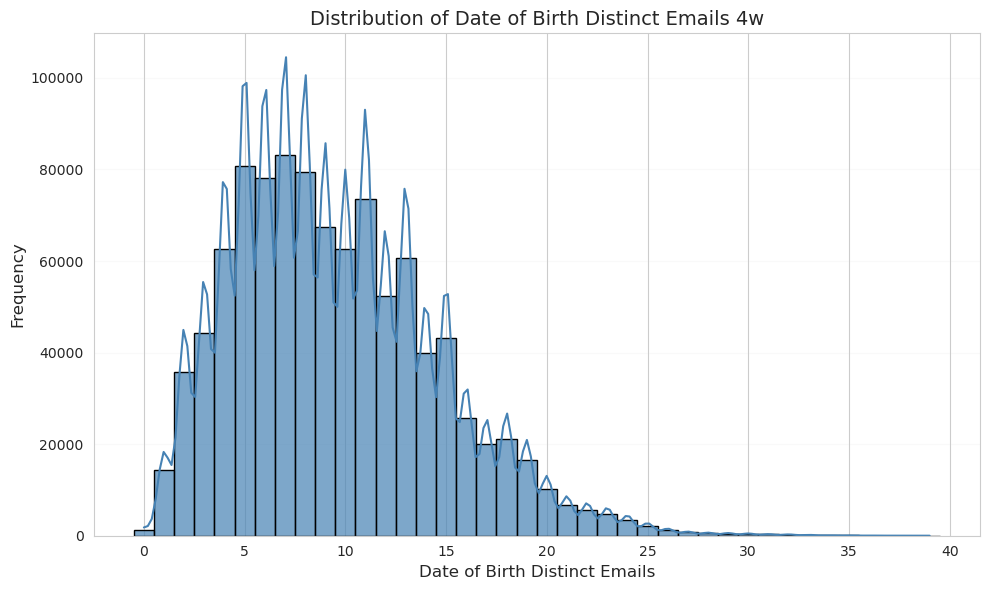

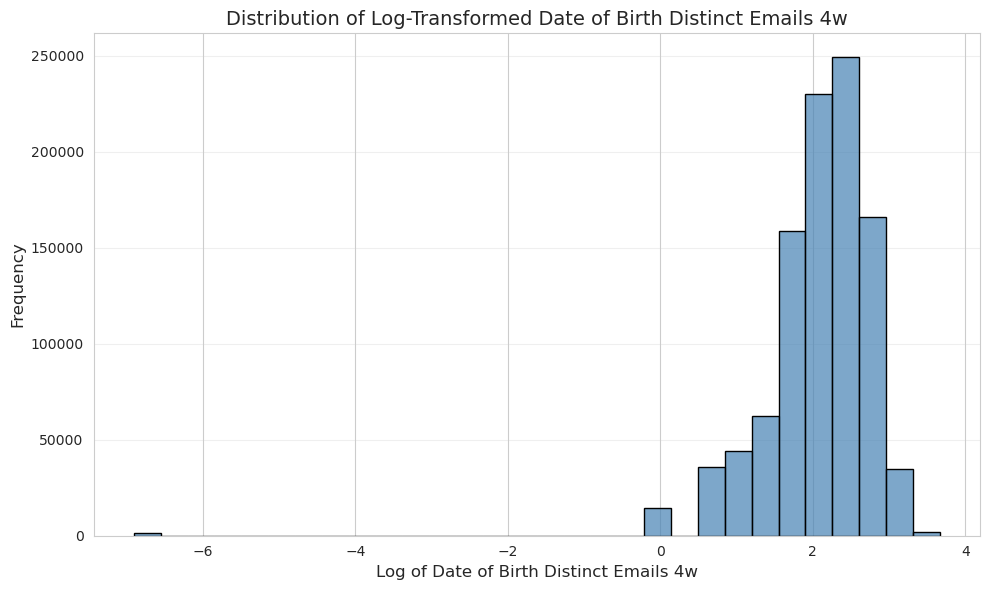

/home/codespace/miniforge3/envs/mlops/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


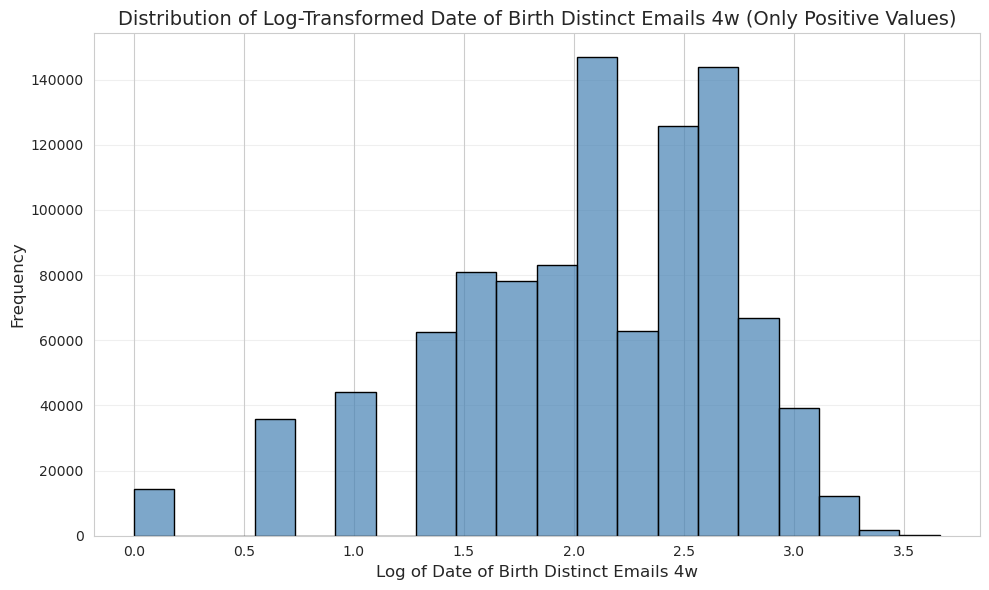

In [26]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['date_of_birth_distinct_emails_4w'], bins=40, kde=True, color='steelblue', edgecolor='black', alpha=0.7,discrete=True)
plt.xlabel('Date of Birth Distinct Emails', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Date of Birth Distinct Emails 4w', fontsize=14)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()
# Log transform date_of_birth_distinct_emails_4w to reduce skewness
dataset['date_of_birth_distinct_emails_4w_log'] = np.log(dataset['date_of_birth_distinct_emails_4w']+0.001)
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset['date_of_birth_distinct_emails_4w_log'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Date of Birth Distinct Emails 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Date of Birth Distinct Emails 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()
# Log transform only the positive values of date_of_birth_distinct_emails_4w
dataset['date_of_birth_distinct_emails_4w_log_original'] = np.log(dataset['date_of_birth_distinct_emails_4w'])

# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(dataset.loc[dataset['date_of_birth_distinct_emails_4w'] > 0, 'date_of_birth_distinct_emails_4w_log_original'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Date of Birth Distinct Emails 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Date of Birth Distinct Emails 4w (Only Positive Values)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

### employment_status

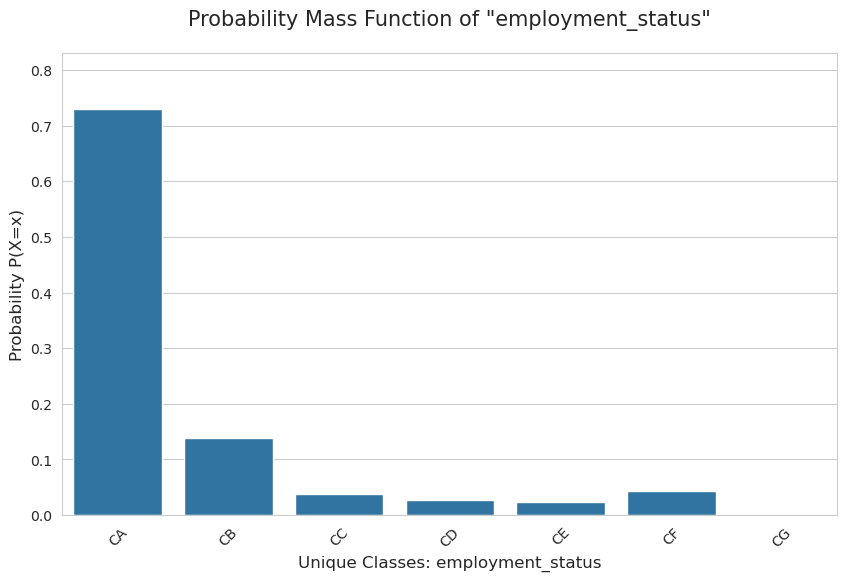

Proportions of employment_status: 
employment_status
CA    0.730252
CB    0.138288
CF    0.044034
CC    0.037758
CD    0.026522
CE    0.022693
CG    0.000453
Name: proportion, dtype: float64


In [27]:
dataset["employment_status"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["employment_status"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["employment_status", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="employment_status", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "employment_status"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: employment_status', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
print(f"Proportions of employment_status: \n{dataset['employment_status'].value_counts(normalize=True)}")

Many classes should be combined later on based on how they affect the target variable.

### credit_risk_score

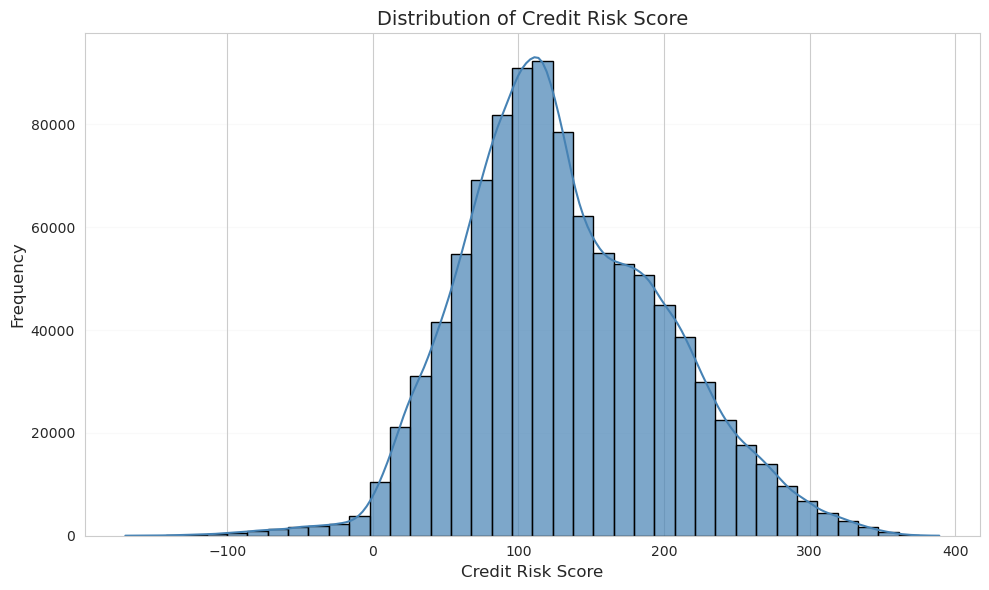

In [28]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['credit_risk_score'], bins=40, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Credit Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Credit Risk Score', fontsize=14)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()

### e-mail_is_free

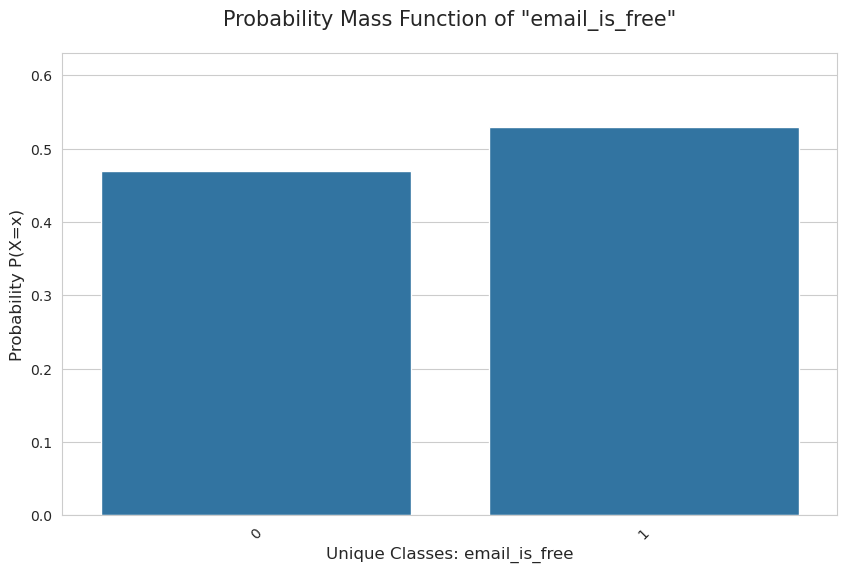

In [29]:
dataset["email_is_free"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["email_is_free"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["email_is_free", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="email_is_free", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "email_is_free"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: email_is_free', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()

### housing_status

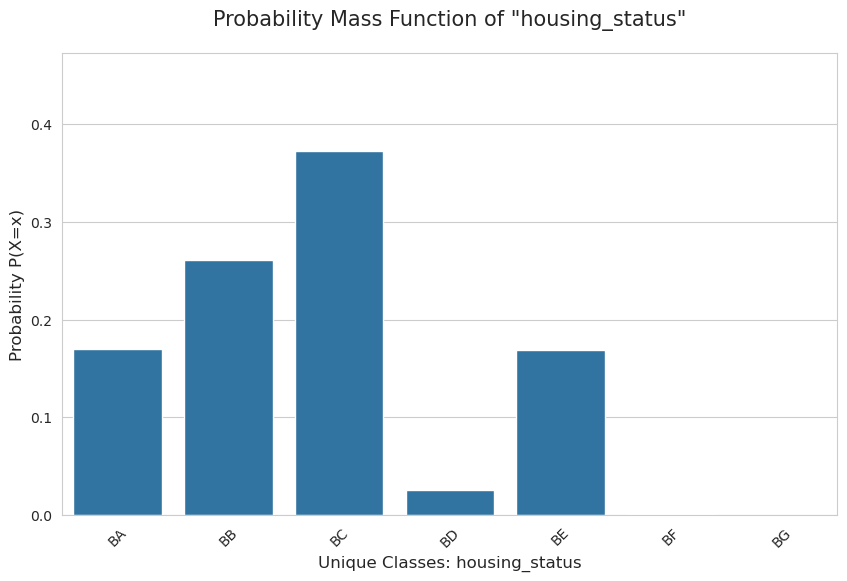

housing_status
BC    0.372143
BB    0.260965
BA    0.169675
BE    0.169135
BD    0.026161
BF    0.001669
BG    0.000252
Name: count, dtype: float64

In [30]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["housing_status"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["housing_status", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="housing_status", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "housing_status"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: housing_status', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["housing_status"].value_counts()/len(dataset)


**Inference**: Some categories can be combined to Other such as BG, BF, BD

In [31]:
# Create an engineered housing_status_engineered column where we group BG, BF, BD as 'Other' and keep the rest as is.
def engineer_housing_status(row):
    if row['housing_status'] in ['BG', 'BF', 'BD']:
        return 'Other'
    else:
        return row['housing_status']
dataset['housing_status_engineered'] = dataset.apply(engineer_housing_status, axis=1)

### phone_home_valid, phone_mobile_valid

In [32]:
dataset["phone_home_valid"]=np.where(dataset["phone_home_valid"]==1, "Valid", "Invalid")
dataset["phone_mobile_valid"]=np.where(dataset["phone_mobile_valid"]==1, "Valid", "Invalid")
dataset["phone_home_and_mobile_valid"]=dataset["phone_home_valid"]+"_"+dataset["phone_mobile_valid"]

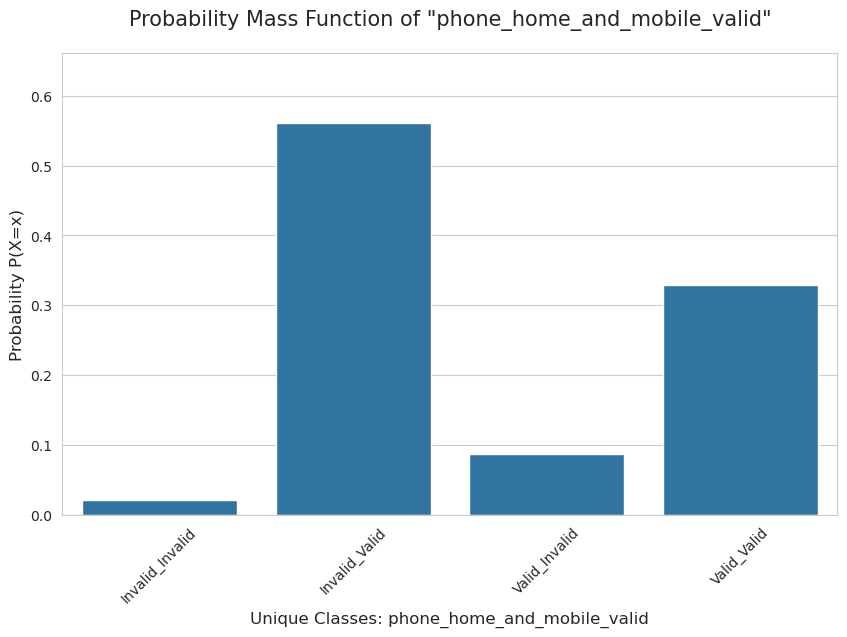

phone_home_and_mobile_valid
Invalid_Valid      0.560691
Valid_Valid        0.328985
Valid_Invalid      0.088092
Invalid_Invalid    0.022232
Name: count, dtype: float64

In [33]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["phone_home_and_mobile_valid"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["phone_home_and_mobile_valid", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="phone_home_and_mobile_valid", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "phone_home_and_mobile_valid"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: phone_home_and_mobile_valid', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["phone_home_and_mobile_valid"].value_counts()/len(dataset)


### proposed_credit_limit

In [34]:
dataset['proposed_credit_limit'].quantile(np.arange(0, 1.01, 0.025))

0.000     190.0
0.025     200.0
0.050     200.0
0.075     200.0
0.100     200.0
0.125     200.0
0.150     200.0
0.175     200.0
0.200     200.0
0.225     200.0
0.250     200.0
0.275     200.0
0.300     200.0
0.325     200.0
0.350     200.0
0.375     200.0
0.400     200.0
0.425     200.0
0.450     200.0
0.475     200.0
0.500     200.0
0.525     200.0
0.550     200.0
0.575     200.0
0.600     200.0
0.625     500.0
0.650     500.0
0.675     500.0
0.700     500.0
0.725     500.0
0.750     500.0
0.775    1000.0
0.800    1000.0
0.825    1000.0
0.850    1500.0
0.875    1500.0
0.900    1500.0
0.925    1500.0
0.950    1500.0
0.975    1500.0
1.000    2100.0
Name: proposed_credit_limit, dtype: float64

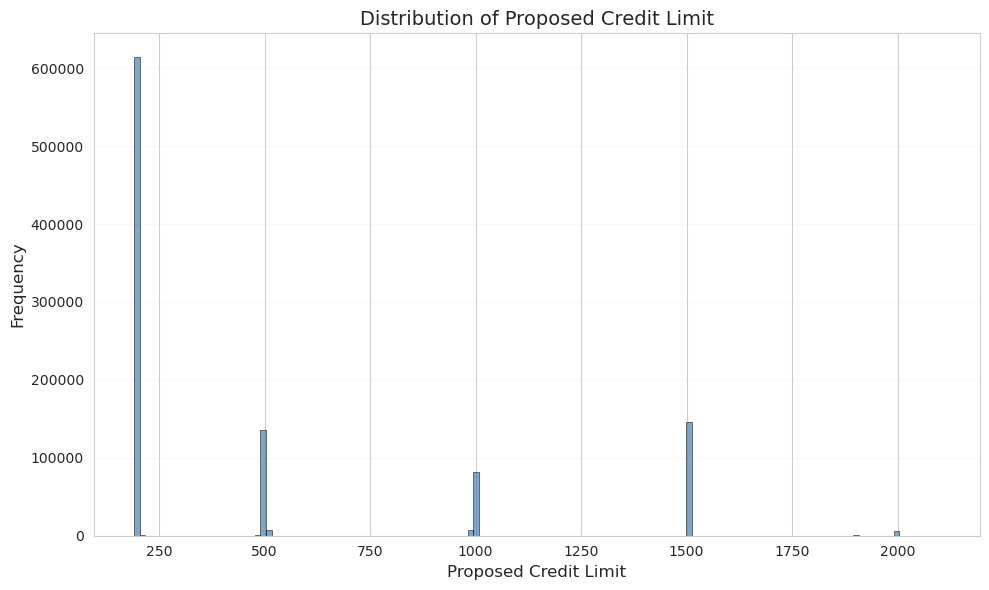

In [35]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(dataset['proposed_credit_limit'], bins=140, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Proposed Credit Limit', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Proposed Credit Limit', fontsize=14)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()
dataset['proposed_credit_limit'].value_counts()
## Discretise bank_branch_count_8w into bins based on quantiles (e.g.60th quantile, 70th, 80th, 90th, 100th)
dataset['proposed_credit_limit_binned'] = pd.cut(dataset['proposed_credit_limit'], bins=[-1, dataset['proposed_credit_limit'].quantile(0.6), dataset['proposed_credit_limit'].quantile(0.8),  dataset['proposed_credit_limit'].max()], labels=['<=200', '200<x<=1000', '1000+'])


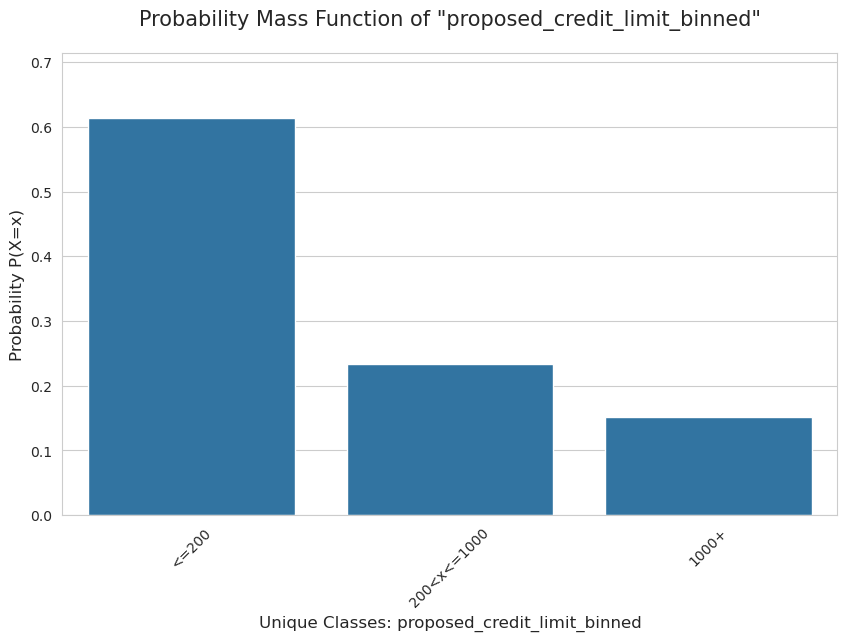

proposed_credit_limit_binned
<=200          0.614017
200<x<=1000    0.233703
1000+          0.152280
Name: count, dtype: float64

In [36]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["proposed_credit_limit_binned"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["proposed_credit_limit_binned", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="proposed_credit_limit_binned", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "proposed_credit_limit_binned"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: proposed_credit_limit_binned', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["proposed_credit_limit_binned"].value_counts()/len(dataset)


### foreign_request

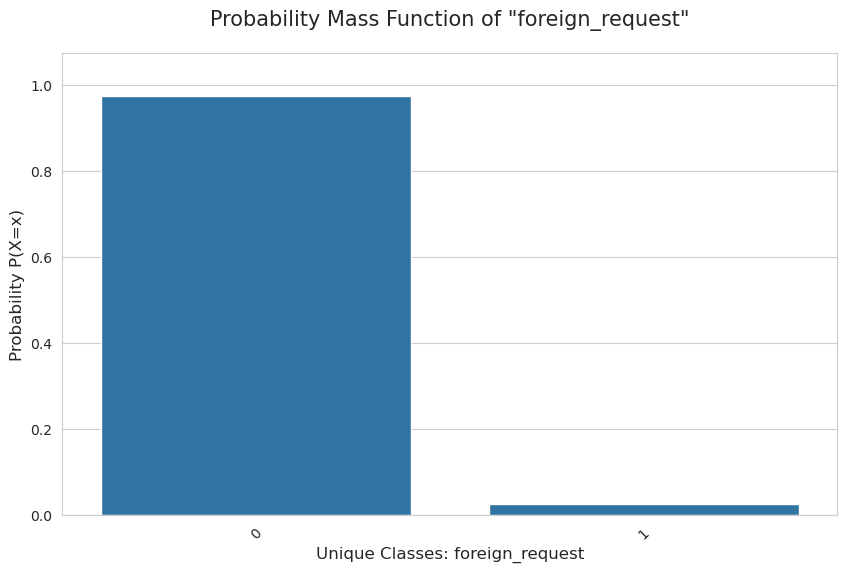

foreign_request
0    0.974758
1    0.025242
Name: count, dtype: float64

In [37]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["foreign_request"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["foreign_request", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="foreign_request", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "foreign_request"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: foreign_request', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["foreign_request"].value_counts()/len(dataset)


### source

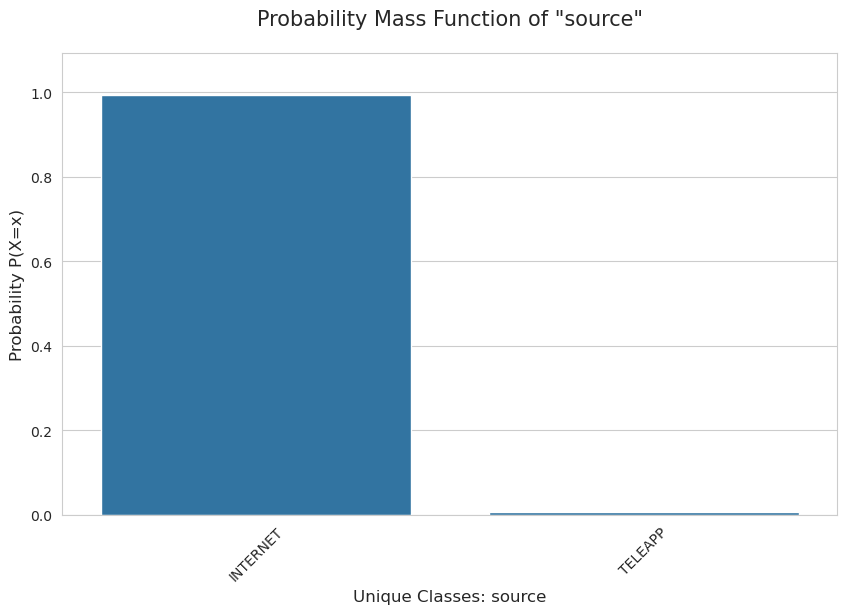

source
INTERNET    0.992952
TELEAPP     0.007048
Name: count, dtype: float64

In [38]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["source"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["source", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="source", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "source"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: source', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["source"].value_counts()/len(dataset)


### session_length_in_minutes

In [39]:
dataset["session_length_in_minutes"].describe()
dataset["session_length_in_minutes"].quantile(np.arange(0.01,1,0.05))


0.01     0.651256
0.06     1.349842
0.11     1.767114
0.16     2.195772
0.21     2.702943
0.26     3.195462
0.31     3.618346
0.36     4.006819
0.41     4.386549
0.46     4.779814
0.51     5.202799
0.56     5.691762
0.61     6.295373
0.66     7.076209
0.71     8.009822
0.76     9.113636
0.81    10.664106
0.86    12.873284
0.91    16.455714
0.96    24.449368
Name: session_length_in_minutes, dtype: float64

/tmp/ipykernel_3131/1247791647.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(positive_session_length, shade=True)


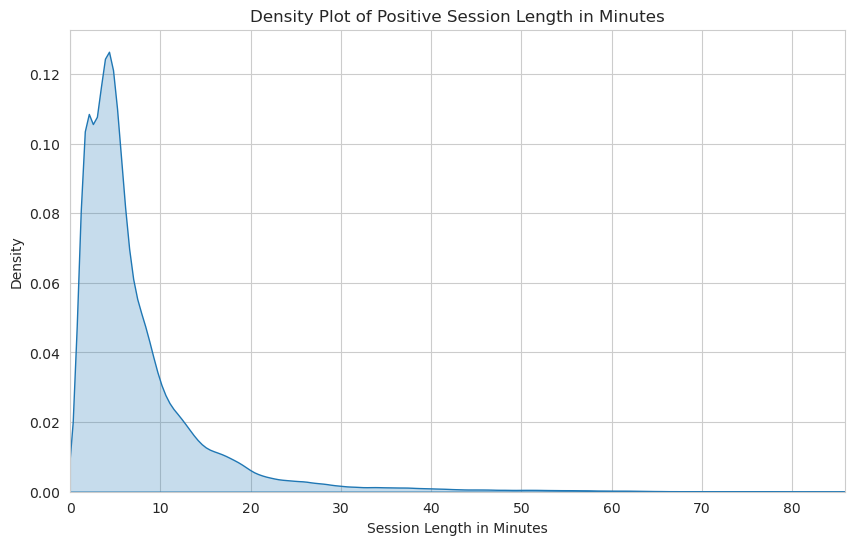

/tmp/ipykernel_3131/1247791647.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(positive_session_length), shade=True)


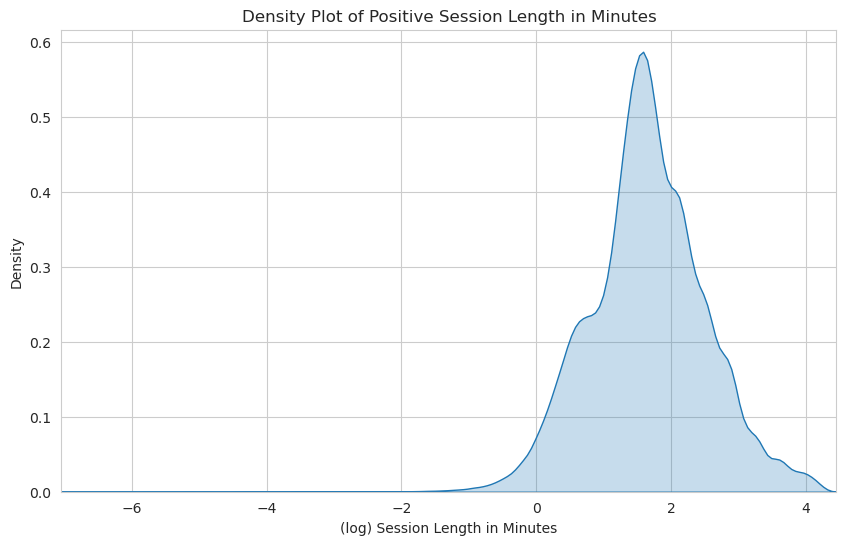

In [ ]:
dataset[(dataset['session_length_in_minutes'] > 0) ]["session_length_in_minutes"].describe()
# Plot a density plot of session_length_in_minutes for positive values

positive_session_length = dataset[(dataset['session_length_in_minutes'] > 0) ]["session_length_in_minutes"]
plt.figure(figsize=(10,6))
sns.kdeplot(positive_session_length, fill=True)
plt.title('Density Plot of Positive Session Length in Minutes')
plt.xlabel('Session Length in Minutes')
plt.ylabel('Density')
plt.xlim(0, positive_session_length.max())
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(np.log(positive_session_length), fill=True)
plt.title('Density Plot of Positive Session Length in Minutes')
plt.xlabel('(log) Session Length in Minutes')
plt.ylabel('Density')
plt.xlim(np.log(positive_session_length).min(), np.log(positive_session_length).max())
plt.show()

### device_os

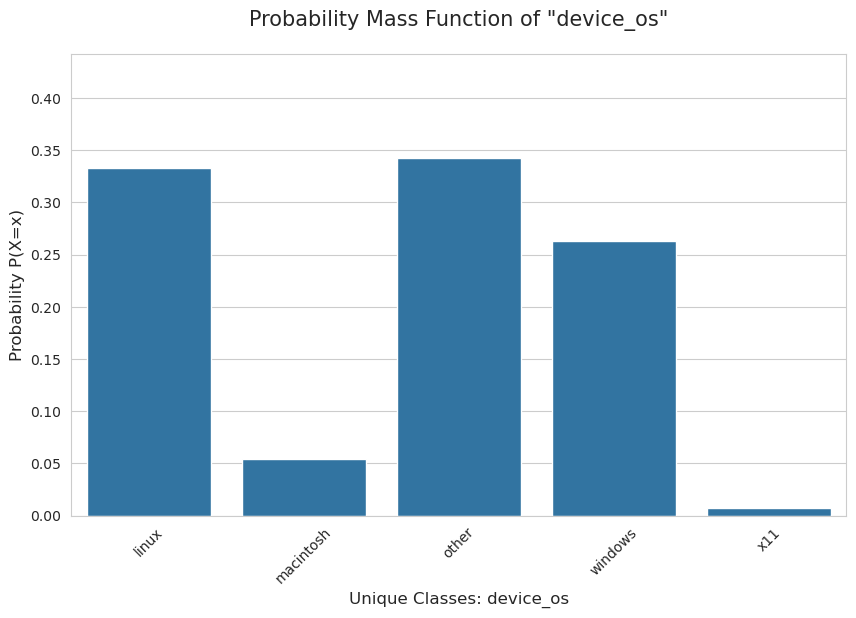

device_os
other        0.342728
linux        0.332712
windows      0.263506
macintosh    0.053826
x11          0.007228
Name: count, dtype: float64

In [41]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["device_os"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["device_os", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="device_os", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "device_os"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: device_os', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["device_os"].value_counts()/len(dataset)


### keep_alive_session

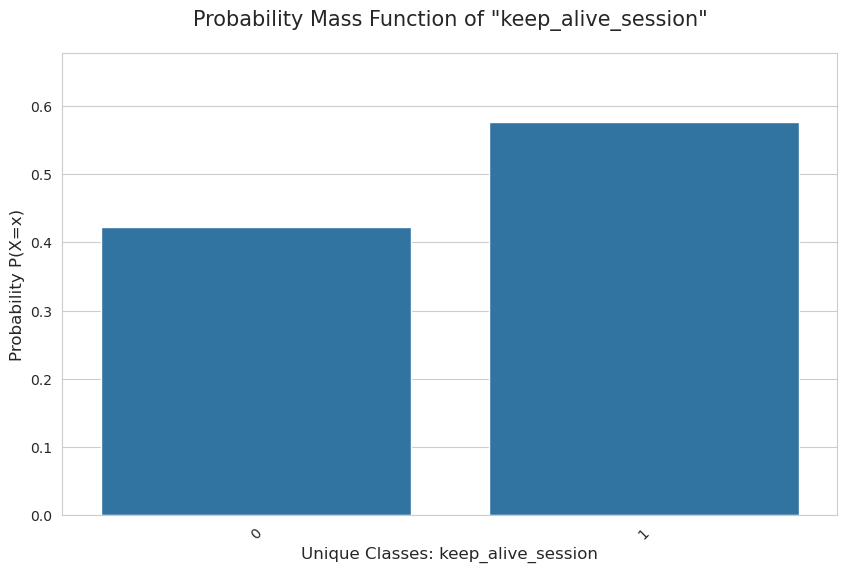

device_os
other        0.342728
linux        0.332712
windows      0.263506
macintosh    0.053826
x11          0.007228
Name: count, dtype: float64

In [42]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["keep_alive_session"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["keep_alive_session", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="keep_alive_session", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "keep_alive_session"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: keep_alive_session', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["device_os"].value_counts()/len(dataset)


### device_distinct_emails

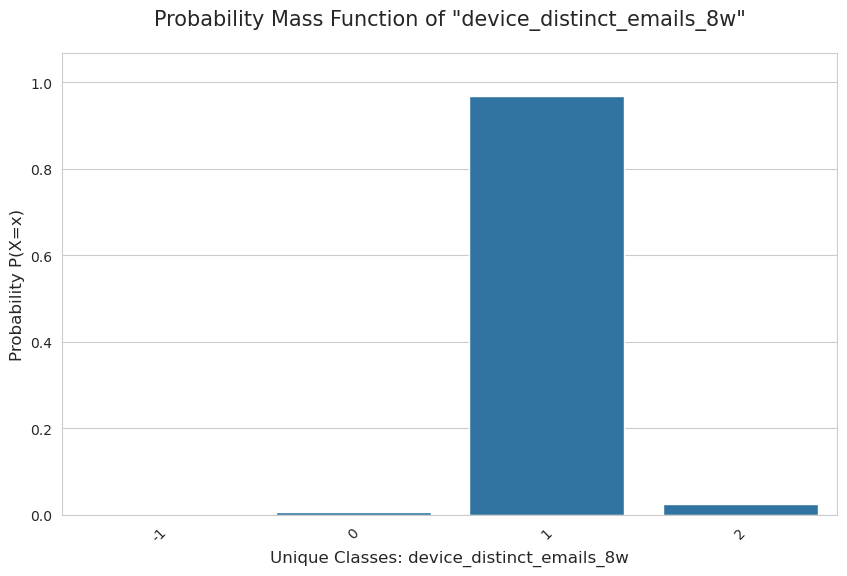

device_distinct_emails_8w
 1    0.968067
 2    0.025302
 0    0.006272
-1    0.000359
Name: count, dtype: float64

In [43]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["device_distinct_emails_8w"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["device_distinct_emails_8w", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="device_distinct_emails_8w", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "device_distinct_emails_8w"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: device_distinct_emails_8w', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["device_distinct_emails_8w"].value_counts()/len(dataset)


### device_fraud_count

In [44]:
dataset["device_fraud_count"].unique()

array([0])

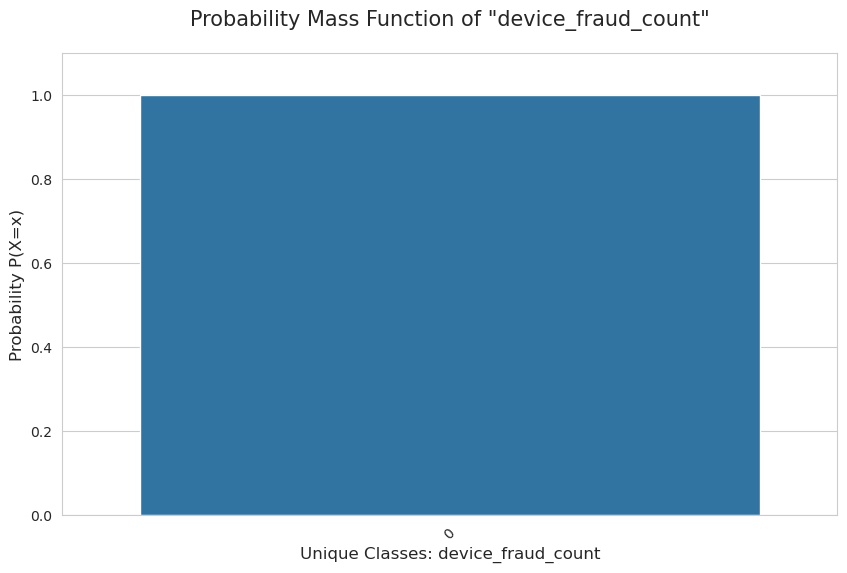

device_fraud_count
0    1.0
Name: count, dtype: float64

In [45]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["device_fraud_count"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["device_fraud_count", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="device_fraud_count", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "device_fraud_count"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: device_fraud_count', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["device_fraud_count"].value_counts()/len(dataset)


### month

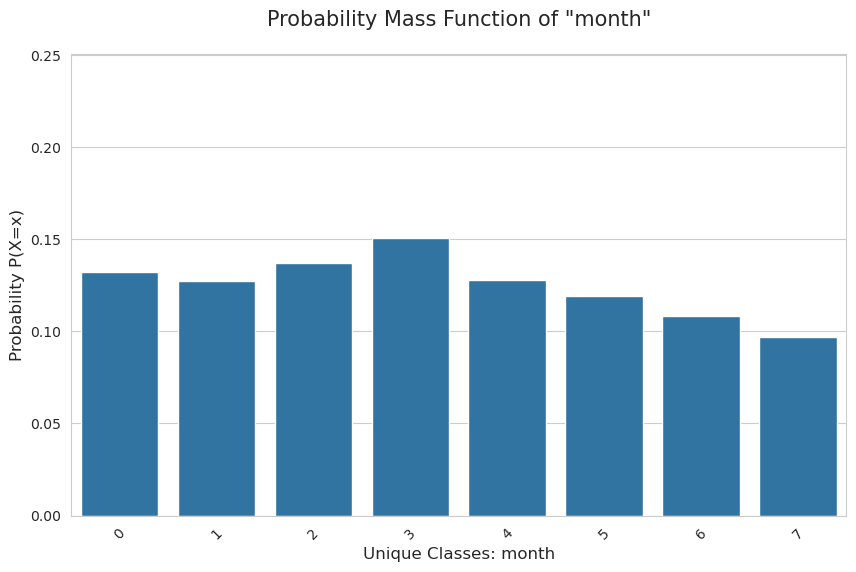

month
3    0.150936
2    0.136979
0    0.132440
4    0.127691
1    0.127620
5    0.119323
6    0.108168
7    0.096843
Name: count, dtype: float64

In [46]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["month"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["month", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="month", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "month"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: month', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["month"].value_counts()/len(dataset)


### fraud_bool

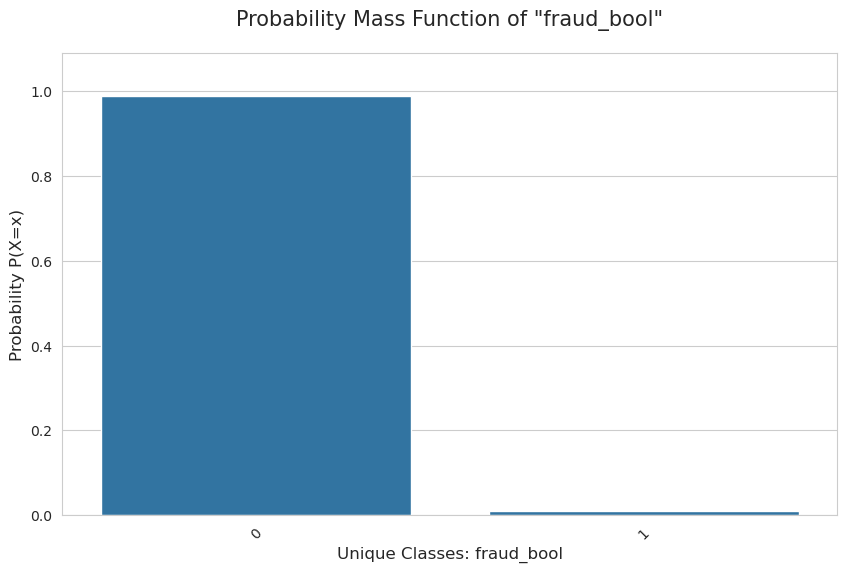

fraud_bool
0    0.988971
1    0.011029
Name: count, dtype: float64

In [47]:
# Make the index column to a column
dataset.reset_index(inplace=True)
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = dataset["fraud_bool"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["fraud_bool", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="fraud_bool", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "fraud_bool"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: fraud_bool', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["fraud_bool"].value_counts()/len(dataset)


**High imbalanced** in favor of non-fraudulent applications

### Interaction of prev_address_months_count, current_address_months_count, has_other_cards & bank_months_count

1) **prev_address_months_count** missing =>  Either the previous address is not recorded or stays in the current address for a long time or not available. In general, it reflects the **residential_stability**
2) **current_address_months_count**: Similar inference also here.
3) **has_other_cards** It reflects the **relationship depth with bank**
4) **bank_months_count** It reflects the banking history stability.

The interactions of the above four represent a customer profile. For example, if first two are valid recorded and the last two variables reflect that this customer has not been known to the bank as well as there is no info about legacy account-age field.

In [48]:
dataset["prev_address_months_count_binary"]=np.where(dataset["prev_address_months_count"]<0,"prev_address_missing","prev_address_valid")
dataset["current_address_months_count_binary"]=np.where(dataset["current_address_months_count"]<0,"current_address_missing","current_address_valid")
dataset["has_other_cards_binary"]=np.where(dataset["has_other_cards"]==1,"has_other_cards_valid","has_other_cards_invalid")
dataset["bank_months_count_binary"]=np.where(dataset["bank_months_count"]<0,"bank_months_missing","bank_months_valid")
# 
dataset["customer_profile"]=dataset["prev_address_months_count_binary"]+"_"+dataset["current_address_months_count_binary"]+"_"+dataset["has_other_cards_binary"]+"_"+dataset["bank_months_count_binary"]
dataset["residential_history_stability"]=dataset["prev_address_months_count_binary"]+"_"+dataset["current_address_months_count_binary"]
dataset["banking_relationship_stability"]=dataset["bank_months_count_binary"]+"_"+dataset["has_other_cards_binary"]

In [49]:
dataset["customer_profile"].value_counts(normalize=True)*100

customer_profile
prev_address_missing_current_address_valid_has_other_cards_invalid_bank_months_valid        40.9365
prev_address_valid_current_address_valid_has_other_cards_invalid_bank_months_valid          15.8032
prev_address_missing_current_address_valid_has_other_cards_valid_bank_months_valid          13.8724
prev_address_missing_current_address_valid_has_other_cards_invalid_bank_months_missing      13.1382
prev_address_valid_current_address_valid_has_other_cards_invalid_bank_months_missing         7.4482
prev_address_valid_current_address_valid_has_other_cards_valid_bank_months_valid             3.7090
prev_address_missing_current_address_valid_has_other_cards_valid_bank_months_missing         3.3363
prev_address_valid_current_address_valid_has_other_cards_valid_bank_months_missing           1.3308
prev_address_valid_current_address_missing_has_other_cards_invalid_bank_months_valid         0.2697
prev_address_valid_current_address_missing_has_other_cards_invalid_bank_months_miss

In [50]:
dataset["residential_history_stability"].value_counts(normalize=True)*100

residential_history_stability
prev_address_missing_current_address_valid      71.2834
prev_address_valid_current_address_valid        28.2912
prev_address_valid_current_address_missing       0.4168
prev_address_missing_current_address_missing     0.0086
Name: proportion, dtype: float64

In [51]:
dataset["banking_relationship_stability"].value_counts(normalize=True)*100

banking_relationship_stability
bank_months_valid_has_other_cards_invalid      57.0151
bank_months_missing_has_other_cards_invalid    20.6861
bank_months_valid_has_other_cards_valid        17.6214
bank_months_missing_has_other_cards_valid       4.6774
Name: proportion, dtype: float64

------------------------------------------------

### Imputation of missing values where needed

1) velocity_6h
2) session_length_in_minutes


In [52]:
# Impute the negative values of velocity_6h using mean imputation
dataset['velocity_6h_imputed'] = np.where(dataset['velocity_6h'] < 0, dataset['velocity_6h'][dataset['velocity_6h'] >= 0].mean(), dataset['velocity_6h'])
dataset['log_velocity_6h_imputed'] = np.log(dataset['velocity_6h_imputed'])
# Impute the negative values of session_length_in_minutes using mean imputation
dataset["session_length_in_minutes_imputed"]=np.where(dataset["session_length_in_minutes"]<0, dataset["session_length_in_minutes"][dataset["session_length_in_minutes"]>=0].mean(),dataset["session_length_in_minutes"])
dataset['log_session_length_in_minutes_imputed'] = np.log(dataset['session_length_in_minutes_imputed'])


### Drop unnecessary variables

In [53]:
dataset.head(3)

,index,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,current_address_months_count_binary,has_other_cards_binary,bank_months_count_binary,customer_profile,residential_history_stability,banking_relationship_stability,velocity_6h_imputed,log_velocity_6h_imputed,session_length_in_minutes_imputed,log_session_length_in_minutes_imputed
0,0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,...,current_address_valid,has_other_cards_invalid,bank_months_valid,prev_address_missing_current_address_valid_has...,prev_address_missing_current_address_valid,bank_months_valid_has_other_cards_invalid,13096.035018,9.480065,16.224843,2.786544
1,1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,...,current_address_valid,has_other_cards_invalid,bank_months_valid,prev_address_missing_current_address_valid_has...,prev_address_missing_current_address_valid,bank_months_valid_has_other_cards_invalid,9223.283431,9.129486,3.363854,1.213087
2,2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,...,current_address_valid,has_other_cards_invalid,bank_months_valid,prev_address_valid_current_address_valid_has_o...,prev_address_valid_current_address_valid,bank_months_valid_has_other_cards_invalid,4471.472149,8.405473,22.730559,3.123710


In [54]:
dataset.drop(columns={"velocity_6h_log","bank_branch_count_8w_log","date_of_birth_distinct_emails_4w_log", 
                      "date_of_birth_distinct_emails_4w_log_original","session_length_in_minutes","session_length_in_minutes_imputed", 
                      "name_email_similarity","velocity_6h","velocity_6h_valid","prev_address_months_count", "current_address_months_count_binary","current_address_months_count", 
                      "phone_home_valid","phone_mobile_valid","has_other_cards","has_other_cards_binary", "index"}, inplace=True)

### Export

In [ ]:
dataset.to_csv("engineered_fraud_dataset_2.csv", index=False)